This Jupyter notebook contains the GNNExplainer method.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import torch

import pickle
import copy

import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

In [2]:
dataset_nr = 2
assert dataset_nr == 1 or 2

# Load all data

Load the nodes

In [3]:
nodes = pd.read_csv(f'output/indexed_nodes_{dataset_nr}.csv')
nodes

index_id                          id   semantic  \
0             0                  MP:0004187  phenotype   
1             1                  ZP:0100138  phenotype   
2             2                 MGI:1346525       gene   
3             3            OMIM:300377.0044    variant   
4             4                  ZP:0002210  phenotype   
...         ...                         ...        ...   
10270     10270                  ZP:0014934  phenotype   
10271     10271  ENSEMBL:ENSCAFG00000011207       gene   
10272     10272  ENSEMBL:ENSXETG00000039922       gene   
10273     10273  ENSEMBL:ENSACAG00000010058       gene   
10274     10274         WBPhenotype:0000019  phenotype   

                                                   label  semantic_id  
0                                          cardia bifida            9  
1      muscle tendon junction myotome increased amoun...            9  
2                                                   Sgcd            5  
3                                         DMD, LYS770TER           11  
4      posterior lateral line neuromast primordium mi...            9  
...                                                  ...          ...  
10270  atrioventricular valve development process qua...            9  
10271                         ENSEMBL:ENSCAFG00000011207            5  
10272                         ENSEMBL:ENSXETG00000039922            5  
10273                         ENSEMBL:ENSACAG00000010058            5  
10274                         pharyngeal pumping reduced            9  

[10275 rows x 5 columns]

Load the Edge2Vec embedding

In [4]:
node_feat = KeyedVectors.load(f'output/w2v_{dataset_nr}.dvectors', mmap='r')

e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
for idx, key in enumerate(node_feat.index_to_key):
    e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(node_feat[key])})
    
e2v_embedding = e2v_embedding.sort_values('Node')
e2v_embedding

Node                                          Embedding
0          0  [0.40247095, -0.3845948, -0.15081137, 0.431301...
1          1  [0.65280753, -0.77770376, 0.42025816, -0.13486...
2          2  [1.0554308, -0.3017892, -0.5273176, 0.18507732...
3          3  [0.07937027, -0.10965026, 0.042475987, 0.48398...
4          4  [0.347987, -0.08308155, 0.7126711, 0.22988968,...
...      ...                                                ...
10270  10270  [0.39331457, -0.18525663, 0.29220355, 0.318986...
10271  10271  [0.8446364, -0.20415954, 0.50082487, 0.7357071...
10272  10272  [-0.15475902, -0.85957384, 1.009266, 1.1616921...
10273  10273  [0.79140633, -0.63430583, 0.89944196, 0.494408...
10274  10274  [0.25945067, -0.25986457, -0.05330717, 0.05300...

[10275 rows x 2 columns]

Load the edges

In [5]:
edges = pd.read_csv(f'output/indexed_edges_{dataset_nr}.csv')
edges

head  \
0      WormBase:WBGene00006787   
1      WormBase:WBGene00006787   
2      WormBase:WBGene00006787   
3      WormBase:WBGene00006787   
4      WormBase:WBGene00006787   
...                        ...   
85987                      458   
85988         OMIM:300377.0080   
85989                     5297   
85990    ClinVarVariant:981988   
85991    ClinVarVariant:584105   

                                              label_head  class_head  \
0                                                 unc-52           5   
1                                                 unc-52           5   
2                                                 unc-52           5   
3                                                 unc-52           5   
4                                                 unc-52           5   
...                                                  ...         ...   
85987                           scopolamine butylbromide           4   
85988                              DMD, IVS62, A-G, -285          11   
85989                                        dacomitinib           4   
85990  NC_000023.11:g.(31875374_31929595)_(31968515_3...          11   
85991        NC_000023.11:g.(?_32595737)_(32699313_?)del          11   

       index_head                        relation                        tail  \
0             304                  interacts with     WormBase:WBGene00003929   
1             304                  interacts with     WormBase:WBGene00006789   
2             304  in orthology relationship with  ENSEMBL:ENSSSCG00000015555   
3             304  in orthology relationship with      ZFIN:ZDB-GENE-021226-3   
4             304  in orthology relationship with  ENSEMBL:ENSOANG00000001050   
...           ...                             ...                         ...   
85987        5945                         targets                      P11229   
85988        1578                    is allele of                   HGNC:2928   
85989        8798                         targets                      P12931   
85990        8189            has affected feature                   HGNC:2928   
85991        9866                causes condition               MONDO:0010679   

                                       label_tail  class_tail  index_tail  \
0                                           pat-2           5        1542   
1                                          unc-54           5        6544   
2                                           LAMC1           5        9268   
3                                           lamc1           5        5387   
4                      ENSEMBL:ENSOANG00000001050           5        2204   
...                                           ...         ...         ...   
85987        Muscarinic acetylcholine receptor M1           6        5919   
85988                                         DMD           5        3310   
85989  Proto-oncogene tyrosine-protein kinase Src           6        2379   
85990                                         DMD           5        3310   
85991                 Duchenne muscular dystrophy           3        1913   

       type  
0         0  
1         0  
2         1  
3         1  
4         1  
...     ...  
85987    17  
85988    15  
85989    17  
85990    11  
85991     2  

[85992 rows x 10 columns]

Initialize a graph with edges and nodes including the embedding features of each node.

In [6]:
G = nx.Graph() # TODO: DiGraph?
for ind, node in e2v_embedding.iterrows(): 
    G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edges.iterrows(): 
    G.add_edge(int(edge['index_head']), int(edge['index_tail']), edge_label = edge['relation'])
  
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.4025, -0.3846, -0.1508,  0.4313, -0.1584, -0.2483, -0.4238,  0.0153,
        -0.4962,  0.1547,  0.1589, -0.4305, -0.0581, -0.1972, -0.2055,  0.5037,
        -0.5105,  0.1909,  0.0012,  0.1537,  0.6672,  0.7506,  0.3028, -0.2849,
         0.3139,  0.3975, -0.7756, -0.2581, -0.0448,  0.2015, -0.0455, -0.1286,
        -0.1689, -0.4998,  0.2879,  0.3030, -0.3495,  0.2530,  0.5342, -0.1021,
        -0.1558, -0.0990,  0.1053,  0.0252, -0.0097, -0.0465, -0.0074, -0.2006,
        -0.5433,  0.1710, -0.0038, -0.0586,  0.2605,  0.3435,  0.1108, -0.2850,
         0.1566, -0.1954, -0.1330,  0.3439, -0.5885, -0.0843, -0.3107, -0.2844])})
(0, 8472, {'edge_label': 'causes condition'})
Number of edges is 55032
Number of nodes is 10275


In [7]:
edge_labels_dict = dict([((n1, n2), G.edges[(n1,n2)]['edge_label']) for n1, n2 in G.edges])
edge_labels_dict

{(0, 8472): 'causes condition',
 (0, 7127): 'causes condition',
 (1, 5387): 'causes condition',
 (2, 2321): 'interacts with',
 (2, 599): 'interacts with',
 (2, 2393): 'interacts with',
 (2, 9929): 'in orthology relationship with',
 (2, 3038): 'interacts with',
 (2, 7693): 'found in',
 (2, 6542): 'enables',
 (2, 4877): 'causes condition',
 (2, 803): 'interacts with',
 (2, 649): 'is part of',
 (2, 4268): 'is part of',
 (2, 4344): 'in orthology relationship with',
 (2, 1195): 'causes condition',
 (2, 7451): 'causes condition',
 (2, 9992): 'causes condition',
 (2, 2800): 'causes condition',
 (2, 2986): 'causes condition',
 (2, 8340): 'interacts with',
 (2, 7355): 'causes condition',
 (2, 7000): 'causes condition',
 (2, 1351): 'causes condition',
 (2, 9823): 'in orthology relationship with',
 (2, 2526): 'in orthology relationship with',
 (2, 3579): 'interacts with',
 (2, 6934): 'in orthology relationship with',
 (2, 5868): 'in orthology relationship with',
 (2, 10173): 'causes condition',
 

Load trained model

In [8]:
from gnn.linkpred_model import LinkPredModel

with open(f'output/best_model_{dataset_nr}_args.pkl', 'rb') as f:
    loaded_args = pickle.load(f)
    
best_model = LinkPredModel(len(e2v_embedding['Embedding'][0]), 
                           loaded_args['hidden_dim'], loaded_args['output_dim'], 
                           loaded_args['layers'], loaded_args['aggr'], 
                           loaded_args['dropout'], loaded_args['device']).to(loaded_args['device'])
best_model.load_state_dict(torch.load(f'output/best_model_{dataset_nr}.pth'))

<All keys matched successfully>

# Explain predictions

In [9]:
x = torch.Tensor(e2v_embedding['Embedding'])
print(x.shape)

torch.Size([10275, 64])


In [10]:
edge_index = torch.Tensor(np.array(G.edges).transpose()).type(torch.int64).long()
print(edge_index.shape)

torch.Size([2, 55032])


In [11]:
from gnn.gnnexplainer import GNNExplainer, visualize_subgraph

def explain_edge(node_idx1, node_idx2):
    explainer = GNNExplainer(best_model,
                             epochs=700, num_hops=1, lr=0.01)
    
    trigger = False
    early_stop = 0
    size = 15   # change size of the explanation graph
    iterations = 50 # number of times GNNExplainer is executed
    
    while not trigger:
        _, edge_mask = explainer.explain_link(node_idx1=node_idx1, node_idx2=node_idx2,
                                              x=x, edge_index=edge_index,
                                              G=G)
        
        G2 = copy.deepcopy(G)
        
        if size is not None:
            limit = edge_mask.sort(descending = True)[0][size]
            print('Contribution threshold is', limit)
        else:
            limit = 0.5
        
        for indx, edge in enumerate(G.edges): 
            if edge_mask[indx] < limit:
                G2.remove_edge(edge[0], edge[1])
        
        trigger = nx.has_path(G2, node_idx1, node_idx2)
        early_stop += 1
        
        if early_stop == iterations and not trigger:
            print('No good explanation found after {} iterations'.format(early_stop))
            trigger = True
        elif trigger: 
            print('Explanation found!')
            return edge_mask, limit
        
    return None, None
    

In [12]:
import ast

symptoms_drugs = pd.read_csv(f'output/symptom_drugs_{dataset_nr}.csv', converters={1:ast.literal_eval})
symptoms_drugs

Symptom          Candidates
0   HP:0003707   [2774, 176, 1043]
1   HP:0003236   [1043, 176, 1971]
2   HP:0001256    [65, 1273, 1971]
3   HP:0001265   [1273, 1971, 176]
4   HP:0001290  [1971, 1043, 2630]
5   HP:0003307   [176, 2774, 1043]
6   HP:0003202  [1273, 1043, 2774]
7   HP:0001263   [1273, 1150, 832]
8   HP:0002791   [1273, 1646, 271]
9   HP:0001371   [1043, 522, 1273]
10  HP:0003701   [1273, 1971, 176]
11  HP:0001270   [1273, 176, 1646]
12  HP:0003560  [1043, 2774, 1273]
13  HP:0008981   [176, 2774, 5345]
14  HP:0002650  [1043, 1273, 5345]
15  HP:0001638   [176, 2774, 1273]
16  HP:0003323    [223, 176, 1971]
17  HP:0001635    [1576, 522, 313]
18  HP:0000750  [1273, 1646, 1920]
19  HP:0003115   [1726, 1043, 223]
20  HP:0011675     [231, 2774, 65]
21  HP:0003391   [2774, 176, 1273]
22  HP:0002093    [1971, 1273, 65]
23  HP:0100543  [1273, 1043, 1646]
24  HP:0001644    [176, 223, 1043]
25  HP:0002515   [176, 1273, 1043]
26  HP:0001328    [65, 1273, 1043]

In [13]:
def get_node_idx(id, nodes): 
    return nodes[nodes['id'] == id].index.values.astype(int)[0]

found_explanation = []

for ind, edge in symptoms_drugs.iterrows(): 
    symptom_id = edge['Symptom']
    
    for drug_id in edge['Candidates']:
        node_idx1 = get_node_idx(symptom_id, nodes)
        print('node1:')
        print(nodes.loc[[node_idx1]])

        node_idx2 = get_node_idx(str(drug_id), nodes)
        print('node2:')
        print(nodes.loc[[node_idx2]])
        
        found_edge_mask, found_limit = explain_edge(node_idx1, node_idx2)
        
        if found_edge_mask is not None and found_limit is not None:
            found_explanation.append({'symptom': symptom_id, 'drug': drug_id, 'node_idx1': node_idx1, 'node_idx2': node_idx2, 'found_edge_mask': found_edge_mask, 'found_limit': found_limit})

node1:
      index_id          id   semantic                          label  \
5727      5727  HP:0003707  phenotype  Calf muscle pseudohypertrophy   

      semantic_id  
5727            9  
node2:
      index_id    id semantic        label  semantic_id
9663      9663  2774     drug  tropicamide            4
Prediction from trained model: tensor([0.7483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9663: 100%|██████████| 700/700 [00:01<00:00, 434.02it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                          label  \
5727      5727  HP:0003707  phenotype  Calf muscle pseudohypertrophy   

      semantic_id  
5727            9  
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.0037], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 772: 100%|██████████| 700/700 [00:01<00:00, 475.84it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                          label  \
5727      5727  HP:0003707  phenotype  Calf muscle pseudohypertrophy   

      semantic_id  
5727            9  
node2:
      index_id    id semantic       label  semantic_id
7315      7315  1043     drug  ergotamine            4
Prediction from trained model: tensor([0.5906], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7315: 100%|██████████| 700/700 [00:01<00:00, 509.24it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                           label  \
1351      1351  HP:0003236  phenotype  Elevated serum creatine kinase   

      semantic_id  
1351            9  
node2:
      index_id    id semantic       label  semantic_id
7315      7315  1043     drug  ergotamine            4
Prediction from trained model: tensor([0.7382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 7315: 100%|██████████| 700/700 [00:01<00:00, 521.85it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                           label  \
1351      1351  HP:0003236  phenotype  Elevated serum creatine kinase   

      semantic_id  
1351            9  
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.9479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 772: 100%|██████████| 700/700 [00:01<00:00, 504.67it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                           label  \
1351      1351  HP:0003236  phenotype  Elevated serum creatine kinase   

      semantic_id  
1351            9  
node2:
      index_id    id semantic          label  semantic_id
5351      5351  1971     drug  nortriptyline            4
Prediction from trained model: tensor([0.7256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 5351: 100%|██████████| 700/700 [00:01<00:00, 448.25it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                          label  \
4533      4533  HP:0001256  phenotype  Intellectual disability, mild   

      semantic_id  
4533            9  
node2:
      index_id  id semantic          label  semantic_id
6640      6640  65     drug  acetylcholine            4
Prediction from trained model: tensor([0.6704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 6640: 100%|██████████| 700/700 [00:01<00:00, 525.56it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                          label  \
4533      4533  HP:0001256  phenotype  Intellectual disability, mild   

      semantic_id  
4533            9  
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.7654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9808: 100%|██████████| 700/700 [00:01<00:00, 515.15it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                          label  \
4533      4533  HP:0001256  phenotype  Intellectual disability, mild   

      semantic_id  
4533            9  
node2:
      index_id    id semantic          label  semantic_id
5351      5351  1971     drug  nortriptyline            4
Prediction from trained model: tensor([0.7730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 5351: 100%|██████████| 700/700 [00:01<00:00, 506.09it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic         label  semantic_id
6515      6515  HP:0001265  phenotype  Hyporeflexia            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.6496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 455.49it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 469.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 466.02it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4768], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 485.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 484.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 472.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 462.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 455.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 437.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4637], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 427.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:02<00:00, 301.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:02<00:00, 333.79it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 405.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 438.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 391.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 428.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 385.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 412.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 362.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 470.93it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 466.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:02<00:00, 312.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 412.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5758], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 409.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6816], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 461.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 429.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 438.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 463.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 468.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 465.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4380], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 465.33it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 460.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 478.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5344], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 459.79it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 468.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3584], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 465.77it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 459.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 451.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 473.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 465.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 472.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 435.23it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 489.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5995], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 496.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 425.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 474.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 428.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6488], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 414.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 472.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9808: 100%|██████████| 700/700 [00:01<00:00, 481.99it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic         label  semantic_id
6515      6515  HP:0001265  phenotype  Hyporeflexia            9
node2:
      index_id    id semantic          label  semantic_id
5351      5351  1971     drug  nortriptyline            4
Prediction from trained model: tensor([0.5219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 488.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 489.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 488.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 464.69it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 470.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 416.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 416.01it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4739], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 441.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 470.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 428.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 477.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 450.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 475.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 456.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4929], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 489.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 448.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 463.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5309], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 462.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 481.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 456.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 449.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 428.70it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 451.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 420.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 451.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 489.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 492.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 462.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 467.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3611], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 481.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 455.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 465.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 455.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 480.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 467.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:03<00:00, 212.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4674], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 422.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 425.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 465.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 446.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 468.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 482.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3870], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 488.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 465.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 486.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 447.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 452.50it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 493.51it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 491.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5351: 100%|██████████| 700/700 [00:01<00:00, 483.69it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic         label  semantic_id
6515      6515  HP:0001265  phenotype  Hyporeflexia            9
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.0874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 492.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0344], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 480.77it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 485.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0463], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 488.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 459.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 449.37it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 465.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 498.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 463.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 488.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 482.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 492.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 469.37it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1018], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 485.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 488.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5566], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 450.59it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.0769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 468.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 444.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 491.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 493.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 476.58it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.1678], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 493.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 474.11it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.0023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 477.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 484.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 461.69it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.0008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 469.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 482.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 461.85it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0029], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 469.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 477.85it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 482.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6657], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 502.04it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.1179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 493.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 490.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0302], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 471.54it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.0066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 474.52it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.1426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 460.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0296], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 451.72it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 455.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0446], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 454.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 439.04it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 426.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:02<00:00, 265.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0686], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 388.69it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0566], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:02<00:00, 301.00it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.0252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 452.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 383.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 468.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 772: 100%|██████████| 700/700 [00:01<00:00, 474.83it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                  label  semantic_id
5372      5372  HP:0001290  phenotype  Generalized hypotonia            9
node2:
      index_id    id semantic          label  semantic_id
5351      5351  1971     drug  nortriptyline            4
Prediction from trained model: tensor([0.4263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 409.07it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 404.95it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:02<00:00, 340.27it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 367.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:02<00:00, 303.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 416.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6037], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 370.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 378.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:02<00:00, 344.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 400.48it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3316], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 396.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 422.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 423.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 364.08it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:02<00:00, 327.17it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 355.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:02<00:00, 347.78it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.3707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:02<00:00, 330.97it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:02<00:00, 308.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 373.44it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 356.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 367.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 418.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 407.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 430.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 417.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 419.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 411.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:02<00:00, 345.20it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:02<00:00, 343.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 367.41it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 410.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5226], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 409.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 430.04it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 423.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 414.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 430.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 418.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 388.92it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2701], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 367.65it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3561], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:02<00:00, 341.29it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:02<00:00, 336.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 398.82it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2367], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 439.88it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 399.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 359.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 427.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 391.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:02<00:00, 343.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5141], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5351: 100%|██████████| 700/700 [00:01<00:00, 364.98it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                  label  semantic_id
5372      5372  HP:0001290  phenotype  Generalized hypotonia            9
node2:
      index_id    id semantic       label  semantic_id
7315      7315  1043     drug  ergotamine            4
Prediction from trained model: tensor([0.6583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 369.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 425.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6141], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 439.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5914], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 434.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7090], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 418.65it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 424.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 434.67it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 434.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 428.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 408.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 427.47it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 428.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7015], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 430.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 433.80it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 425.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7341], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 439.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 426.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 403.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 414.81it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7422], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 426.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 434.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 398.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8321], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 428.32it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 395.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 392.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 399.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 433.96it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7448], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 403.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 406.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:02<00:00, 343.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:02<00:00, 347.32it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 419.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 392.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:02<00:00, 342.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8821], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:02<00:00, 298.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 403.23it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 401.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 384.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6646], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 385.13it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:02<00:00, 315.44it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:02<00:00, 327.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6071], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:02<00:00, 330.72it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:02<00:00, 315.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8146], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:02<00:00, 344.97it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6646], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 377.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 416.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:02<00:00, 340.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:02<00:00, 316.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:01<00:00, 350.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7315: 100%|██████████| 700/700 [00:02<00:00, 341.00it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                  label  semantic_id
5372      5372  HP:0001290  phenotype  Generalized hypotonia            9
node2:
      index_id    id semantic             label  semantic_id
7833      7833  2630     drug  thiethylperazine            4
Prediction from trained model: tensor([0.4395], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 322.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 341.58it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 422.02it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3949], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 395.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 399.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 430.33it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1507], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 423.20it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 388.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 417.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 422.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 412.11it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 420.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 409.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 431.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 391.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2827], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 425.63it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 337.40it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7880], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 348.25it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 404.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 428.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 353.27it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 327.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 321.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1141], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 325.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 345.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 320.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 364.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5515], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 410.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 370.39it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 332.24it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3321], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 333.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8576], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 321.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 329.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 367.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 436.69it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 288.38it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 316.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 350.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6054], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 326.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 347.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3031], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 377.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 339.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2666], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 368.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4647], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 379.82it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 357.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2366], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 449.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2827], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 366.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4701], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 380.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:02<00:00, 321.77it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1362], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 7833: 100%|██████████| 700/700 [00:01<00:00, 370.90it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic          label  semantic_id
2737      2737  HP:0003307  phenotype  Hyperlordosis            9
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.0008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 772: 100%|██████████| 700/700 [00:01<00:00, 491.57it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic          label  semantic_id
2737      2737  HP:0003307  phenotype  Hyperlordosis            9
node2:
      index_id    id semantic        label  semantic_id
9663      9663  2774     drug  tropicamide            4
Prediction from trained model: tensor([0.4643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9663: 100%|██████████| 700/700 [00:01<00:00, 406.20it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic          label  semantic_id
2737      2737  HP:0003307  phenotype  Hyperlordosis            9
node2:
      index_id    id semantic       label  semantic_id
7315      7315  1043     drug  ergotamine            4
Prediction from trained model: tensor([0.4838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 7315: 100%|██████████| 700/700 [00:01<00:00, 421.42it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic                    label  semantic_id
788       788  HP:0003202  phenotype  Skeletal muscle atrophy            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.4576], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9808: 100%|██████████| 700/700 [00:01<00:00, 470.55it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic                    label  semantic_id
788       788  HP:0003202  phenotype  Skeletal muscle atrophy            9
node2:
      index_id    id semantic       label  semantic_id
7315      7315  1043     drug  ergotamine            4
Prediction from trained model: tensor([0.5704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 7315: 100%|██████████| 700/700 [00:01<00:00, 411.16it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic                    label  semantic_id
788       788  HP:0003202  phenotype  Skeletal muscle atrophy            9
node2:
      index_id    id semantic        label  semantic_id
9663      9663  2774     drug  tropicamide            4
Prediction from trained model: tensor([0.1684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9663: 100%|██████████| 700/700 [00:01<00:00, 460.62it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                       label  semantic_id
7259      7259  HP:0001263  phenotype  Global developmental delay            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.5592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 325.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 338.24it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 364.65it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 371.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 316.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 394.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 302.48it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 387.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 375.62it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6029], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 380.87it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 367.53it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 345.05it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6193], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 320.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3291], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 394.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 330.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 368.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 357.44it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 325.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 342.50it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 329.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 351.24it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 398.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 353.62it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 400.41it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 368.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2882], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 332.35it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 351.24it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5440], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 352.17it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 355.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 349.95it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 340.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3763], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 357.58it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 386.13it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 364.82it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.2508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 357.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 389.77it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 352.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 350.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 342.81it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7504], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 350.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 339.24it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 380.17it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5625], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:01<00:00, 359.71it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.4308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 287.60it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.4756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 283.14it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.4455], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 322.24it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2526], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 335.71it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2390], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 341.78it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 317.60it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9808: 100%|██████████| 700/700 [00:02<00:00, 340.18it/s]


Contribution threshold is tensor(0.9939)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                       label  semantic_id
7259      7259  HP:0001263  phenotype  Global developmental delay            9
node2:
      index_id    id semantic         label  semantic_id
4369      4369  1150     drug  fenfluramine            4
Prediction from trained model: tensor([0.0205], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 345.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0222], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 339.65it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6070], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 360.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 365.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 356.30it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 368.01it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0254], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 366.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 348.68it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0047], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 362.51it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 348.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0282], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 344.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 346.63it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 363.01it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 315.62it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 348.92it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0047], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 369.69it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 362.97it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.1797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 331.23it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 318.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 352.92it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3310], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 356.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 331.41it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 317.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 317.70it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 360.71it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 354.32it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0132], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 365.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 366.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 337.04it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 309.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 325.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 329.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 347.40it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 313.41it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 309.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0976], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 309.58it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 362.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 386.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 338.95it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 323.63it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 341.81it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.1664], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 360.22it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.3005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 408.92it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2625], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 434.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 332.85it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 383.04it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 331.27it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0054], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:02<00:00, 342.08it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 362.79it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0029], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4369: 100%|██████████| 700/700 [00:01<00:00, 379.49it/s]


Contribution threshold is tensor(0.9939)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                       label  semantic_id
7259      7259  HP:0001263  phenotype  Global developmental delay            9
node2:
      index_id   id semantic            label  semantic_id
2100      2100  832     drug  dexfenfluramine            4
Prediction from trained model: tensor([0.0360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 356.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 291.71it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0629], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 353.37it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 344.51it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.4765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 344.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 314.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 356.59it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.2656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 307.38it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 340.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 347.51it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 354.43it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 352.27it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 349.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 356.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0302], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 334.49it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.1445], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 324.59it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0135], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 328.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 332.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8520], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 323.33it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.2010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 329.81it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 327.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 331.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 328.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 335.41it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2007], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 357.36it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 321.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 314.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 314.88it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 347.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 327.69it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 337.61it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 353.48it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 441.38it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 331.21it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 422.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 329.11it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 350.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 392.30it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 409.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 379.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 324.17it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 310.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 311.85it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 345.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 352.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0735], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 349.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 355.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:01<00:00, 357.85it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.0423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 349.47it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 2100: 100%|██████████| 700/700 [00:02<00:00, 347.13it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic            label  semantic_id
1682      1682  HP:0002791  phenotype  Hypoventilation            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.6726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 9808: 100%|██████████| 700/700 [00:01<00:00, 454.36it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic            label  semantic_id
1682      1682  HP:0002791  phenotype  Hypoventilation            9
node2:
      index_id    id semantic         label  semantic_id
6955      6955  1646     drug  mecamylamine            4
Prediction from trained model: tensor([0.3576], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 6955: 100%|██████████| 700/700 [00:01<00:00, 433.17it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic            label  semantic_id
1682      1682  HP:0002791  phenotype  Hypoventilation            9
node2:
      index_id   id semantic       label  semantic_id
9539      9539  271     drug  azelastine            4
Prediction from trained model: tensor([0.3632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 9539: 100%|██████████| 700/700 [00:01<00:00, 396.54it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                label  semantic_id
5052      5052  HP:0001371  phenotype  Flexion contracture            9
node2:
      index_id    id semantic       label  semantic_id
7315      7315  1043     drug  ergotamine            4
Prediction from trained model: tensor([0.6233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 406.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 408.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 391.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 399.92it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 409.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 389.93it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 405.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 399.29it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5132], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 391.38it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 409.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 412.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6737], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 458.42it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 358.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 402.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4455], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 402.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 388.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 359.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 383.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 394.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5448], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 408.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 403.44it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8235], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 390.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 401.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 405.49it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 406.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5530], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 399.35it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 384.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 403.92it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3649], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 401.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 404.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 408.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 405.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6357], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 405.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 400.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 381.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 393.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 405.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 406.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 405.71it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 408.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 394.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 405.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 411.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6011], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 404.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 401.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 407.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 418.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4310], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 411.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 398.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 7315: 100%|██████████| 700/700 [00:01<00:00, 403.43it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                label  semantic_id
5052      5052  HP:0001371  phenotype  Flexion contracture            9
node2:
      index_id   id semantic       label  semantic_id
2882      2882  522     drug  carvedilol            4
Prediction from trained model: tensor([0.5952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 2882: 100%|██████████| 700/700 [00:01<00:00, 404.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 2882: 100%|██████████| 700/700 [00:01<00:00, 411.37it/s]


Contribution threshold is tensor(0.0064)
Explanation found!
node1:
      index_id          id   semantic                label  semantic_id
5052      5052  HP:0001371  phenotype  Flexion contracture            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.3584], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 386.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 398.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6729], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 387.63it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5073], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 393.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 400.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 401.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 403.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4646], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 404.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:02<00:00, 322.62it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 401.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 411.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 401.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 394.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 407.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:02<00:00, 334.63it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 410.36it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 375.98it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 367.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 357.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 381.62it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 392.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 403.52it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 406.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 397.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 391.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 395.67it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 404.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 400.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 412.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3759], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 415.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 366.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 393.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 396.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6396], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 389.40it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 388.47it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 381.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 370.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 393.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 398.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4359], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 365.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 393.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 394.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 392.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 399.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 398.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 402.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 403.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 397.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 398.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9808: 100%|██████████| 700/700 [00:01<00:00, 396.98it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                     label  semantic_id
5762      5762  HP:0003701  phenotype  Proximal muscle weakness            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.3346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 366.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 380.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 377.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 352.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 375.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 367.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5007], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 374.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:02<00:00, 339.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:02<00:00, 320.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:02<00:00, 333.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 388.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 371.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4190], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 379.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 379.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 376.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5314], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 386.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 388.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 375.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 378.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 383.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7123], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 358.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 371.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 381.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 385.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 378.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6850], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 377.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 385.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 387.10it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:02<00:00, 326.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 462.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6716], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 380.33it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 381.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6879], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 352.94it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:02<00:00, 345.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 357.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 369.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 464.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:02<00:00, 343.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:02<00:00, 338.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 374.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 428.95it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 371.94it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4882], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 362.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 359.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 359.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 360.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 382.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 396.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7218], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 465.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9808: 100%|██████████| 700/700 [00:01<00:00, 477.17it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                     label  semantic_id
5762      5762  HP:0003701  phenotype  Proximal muscle weakness            9
node2:
      index_id    id semantic          label  semantic_id
5351      5351  1971     drug  nortriptyline            4
Prediction from trained model: tensor([0.4036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 480.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5827], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 482.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 407.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 475.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 471.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 445.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 434.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 468.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 478.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1934], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 468.55it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 459.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 474.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 474.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 475.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 480.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 478.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 472.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 475.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4995], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 482.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 472.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 480.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 475.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 476.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 471.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 477.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 467.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 430.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 481.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 473.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 484.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 478.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 488.79it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 487.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 455.91it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 483.81it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6276], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 492.50it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1860], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 482.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 482.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 484.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 482.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 446.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5856], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 473.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 487.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 463.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5258], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 477.62it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 479.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4344], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 422.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 454.94it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 485.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4603], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5351: 100%|██████████| 700/700 [00:01<00:00, 473.60it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                     label  semantic_id
5762      5762  HP:0003701  phenotype  Proximal muscle weakness            9
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.1211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 468.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 481.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 485.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 479.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 406.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 458.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 467.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0798], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 452.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 429.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 453.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2521], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 435.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 427.34it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 469.11it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 449.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 420.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0434], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 446.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:02<00:00, 318.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 390.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 422.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3615], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 471.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3502], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 431.01it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 407.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 459.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 395.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5413], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 365.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 438.85it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2254], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 435.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 382.16it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 452.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 379.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 470.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 460.37it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0221], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 481.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 478.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 473.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 447.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3863], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 468.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 490.33it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 475.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 447.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 478.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 469.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0222], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 481.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 478.42it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 403.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 434.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 471.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6042], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 381.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 433.66it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 772: 100%|██████████| 700/700 [00:01<00:00, 389.95it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic        label  semantic_id
1429      1429  HP:0001270  phenotype  Motor delay            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.7231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9808: 100%|██████████| 700/700 [00:01<00:00, 540.05it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic        label  semantic_id
1429      1429  HP:0001270  phenotype  Motor delay            9
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.0004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 772: 100%|██████████| 700/700 [00:01<00:00, 487.72it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic        label  semantic_id
1429      1429  HP:0001270  phenotype  Motor delay            9
node2:
      index_id    id semantic         label  semantic_id
6955      6955  1646     drug  mecamylamine            4
Prediction from trained model: tensor([0.8478], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 6955: 100%|██████████| 700/700 [00:01<00:00, 506.09it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic               label  semantic_id
898       898  HP:0003560  phenotype  Muscular dystrophy            9
node2:
      index_id    id semantic       label  semantic_id
7315      7315  1043     drug  ergotamine            4
Prediction from trained model: tensor([0.4361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 7315: 100%|██████████| 700/700 [00:01<00:00, 519.76it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic               label  semantic_id
898       898  HP:0003560  phenotype  Muscular dystrophy            9
node2:
      index_id    id semantic        label  semantic_id
9663      9663  2774     drug  tropicamide            4
Prediction from trained model: tensor([0.6488], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 466.65it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic               label  semantic_id
898       898  HP:0003560  phenotype  Muscular dystrophy            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.5791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9808: 100%|██████████| 700/700 [00:01<00:00, 431.38it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                    label  semantic_id
4673      4673  HP:0008981  phenotype  Calf muscle hypertrophy            9
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.7324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 458.68it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 501.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.1720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 503.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9497], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 447.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 461.39it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0526], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 518.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 495.26it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 462.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 465.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 389.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9507], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 444.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 451.28it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 471.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 505.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 424.10it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8123], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 463.62it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 469.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2014], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 376.79it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 385.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 438.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 379.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 363.65it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 428.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 392.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 442.63it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 431.86it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 437.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 428.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 391.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 412.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 413.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 416.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.1711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 411.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 416.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3497], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 463.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1336], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 421.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 498.69it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 387.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 404.66it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.2972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 458.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 430.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0221], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 450.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 454.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 432.69it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 469.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 439.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 457.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 485.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 469.49it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 772: 100%|██████████| 700/700 [00:01<00:00, 469.74it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                    label  semantic_id
4673      4673  HP:0008981  phenotype  Calf muscle hypertrophy            9
node2:
      index_id    id semantic        label  semantic_id
9663      9663  2774     drug  tropicamide            4
Prediction from trained model: tensor([0.5682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 428.95it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 470.53it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 476.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 433.10it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 469.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 448.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5328], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 437.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 396.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5309], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 491.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 461.06it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4825], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 462.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 456.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 443.35it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 475.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 496.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 477.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 450.07it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 486.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 496.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 424.89it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 502.23it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 494.02it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 444.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 470.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 504.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 503.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 478.87it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 419.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4321], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 484.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 493.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 493.16it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5281], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 503.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5365], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 484.38it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 477.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3110], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 483.87it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 472.96it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 490.96it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 497.96it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.2562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 497.34it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8205], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 499.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 490.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3618], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 494.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4712], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 481.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 494.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 503.02it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 492.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 507.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 440.62it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4254], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 484.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9663: 100%|██████████| 700/700 [00:01<00:00, 499.65it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                    label  semantic_id
4673      4673  HP:0008981  phenotype  Calf muscle hypertrophy            9
node2:
      index_id    id semantic        label  semantic_id
2695      2695  5345     drug  entrectinib            4
Prediction from trained model: tensor([0.7619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 516.97it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 486.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7018], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 515.75it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 501.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 499.33it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 476.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 465.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 496.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 481.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5188], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 500.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 496.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 502.25it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 460.21it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 500.98it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7716], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 505.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 490.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7316], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 494.34it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 444.81it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 424.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6625], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 453.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 492.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 488.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 435.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 485.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 509.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 502.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 487.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 462.29it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7368], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 499.87it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5864], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 492.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 474.00it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 482.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 422.35it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 501.67it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 478.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 503.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 475.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 429.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 460.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5420], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 469.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 500.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 499.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 415.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 491.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6080], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 503.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4821], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 504.01it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 503.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 511.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 505.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 2695: 100%|██████████| 700/700 [00:01<00:00, 496.78it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic      label  semantic_id
4540      4540  HP:0002650  phenotype  Scoliosis            9
node2:
      index_id    id semantic       label  semantic_id
7315      7315  1043     drug  ergotamine            4
Prediction from trained model: tensor([0.8034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 458.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 470.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 466.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5657], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 460.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 458.47it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 462.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 453.30it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7054], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 464.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 454.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 424.82it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 396.44it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8441], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 381.17it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 462.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 450.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 457.88it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 462.30it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 453.65it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7492], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 463.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 450.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 378.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 461.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 453.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 454.48it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8185], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 420.30it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 448.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 450.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 448.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 445.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 438.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 409.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 436.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 459.67it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 449.80it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 458.32it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 448.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6880], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 456.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 448.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4515], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 431.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 454.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7589], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 449.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 451.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 459.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 461.23it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7303], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 448.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 440.02it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 432.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7759], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 436.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5779], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 442.37it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7258], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 458.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 7315: 100%|██████████| 700/700 [00:01<00:00, 407.16it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic      label  semantic_id
4540      4540  HP:0002650  phenotype  Scoliosis            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.7884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 436.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 442.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 459.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 439.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 448.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 431.37it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 438.67it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 454.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 459.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 456.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 459.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 456.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 459.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 447.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 448.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 462.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 460.38it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 448.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 461.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 427.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8170], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 434.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 459.95it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4611], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 448.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 425.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 423.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 451.47it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 461.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 466.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 467.77it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 454.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 445.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 437.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 448.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 430.47it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6495], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 424.66it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 443.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 461.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3440], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 435.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 469.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 449.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 444.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 441.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6657], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 449.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5956], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 438.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 471.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 456.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5846], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 431.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 446.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 460.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9808: 100%|██████████| 700/700 [00:01<00:00, 459.71it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic      label  semantic_id
4540      4540  HP:0002650  phenotype  Scoliosis            9
node2:
      index_id    id semantic        label  semantic_id
2695      2695  5345     drug  entrectinib            4
Prediction from trained model: tensor([0.7447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 453.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 446.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 446.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 445.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 447.80it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 437.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 447.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 483.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 449.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 404.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 433.62it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 420.78it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 458.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 451.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 453.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 461.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 447.17it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 442.38it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7830], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 451.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 442.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 427.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 449.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 432.92it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 2695: 100%|██████████| 700/700 [00:01<00:00, 472.90it/s]


Contribution threshold is tensor(0.9937)
Explanation found!
node1:
      index_id          id   semantic           label  semantic_id
3222      3222  HP:0001638  phenotype  Cardiomyopathy            9
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.0023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 462.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 443.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 465.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0365], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 467.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 468.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 440.58it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 456.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0186], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 443.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 462.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1834], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 457.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 453.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 451.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0014], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 433.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 461.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0011], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 482.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 442.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 476.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0205], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 456.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0047], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 445.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 462.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5396], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 469.28it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0615], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 479.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 474.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 470.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 478.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 424.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1538], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 439.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 450.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 470.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 463.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 464.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 467.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 460.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 451.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 463.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 438.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0042], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 466.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 441.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 471.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1359], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 471.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 447.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 463.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 446.95it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 466.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 475.84it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 449.06it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 458.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 473.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 464.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 468.53it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic           label  semantic_id
3222      3222  HP:0001638  phenotype  Cardiomyopathy            9
node2:
      index_id    id semantic        label  semantic_id
9663      9663  2774     drug  tropicamide            4
Prediction from trained model: tensor([0.4763], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 461.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 431.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 463.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 451.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7560], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 449.10it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 432.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7414], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 441.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4960], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 446.23it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 441.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7141], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 447.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5879], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 412.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 444.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 454.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5286], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 441.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4478], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 453.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 412.00it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 418.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 472.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 440.92it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 428.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 452.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 464.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 449.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 439.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 457.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 462.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 448.67it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 452.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 450.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 462.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 446.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 451.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 461.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 450.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 441.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 403.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 422.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 443.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 428.79it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 437.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 423.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 426.29it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 419.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 428.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7353], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 427.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 409.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 408.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 438.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 441.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9663: 100%|██████████| 700/700 [00:01<00:00, 441.08it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic           label  semantic_id
3222      3222  HP:0001638  phenotype  Cardiomyopathy            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.4921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 432.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 436.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 457.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 439.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 454.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 424.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 435.32it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 456.94it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 461.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 432.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3579], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 467.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 420.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4752], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 433.73it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 450.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 466.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 458.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3872], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 459.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 451.77it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 459.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 448.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 439.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5077], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 462.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 455.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 450.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 463.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 406.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 420.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 464.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4576], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 447.02it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 445.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 462.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 439.57it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 445.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 426.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 458.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 446.95it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 451.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 461.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6910], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 461.10it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 439.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 470.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5337], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 469.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 452.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 460.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 430.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 356.95it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 429.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 441.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 464.28it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 9808: 100%|██████████| 700/700 [00:01<00:00, 431.71it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
       index_id          id   semantic                        label  \
10187     10187  HP:0003323  phenotype  Progressive muscle weakness   

       semantic_id  
10187            9  
node2:
      index_id   id semantic                      label  semantic_id
2150      2150  223     drug  octatropine methylbromide            4
Prediction from trained model: tensor([0.1134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 471.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 466.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 476.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 441.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 396.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 425.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0029], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 385.49it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 466.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 415.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 371.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 359.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:02<00:00, 345.44it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 414.98it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:02<00:00, 338.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([7.0867e-06], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 356.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 360.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 385.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([3.1131e-05], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 351.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 370.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0011], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 353.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 389.29it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([8.6443e-05], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 372.46it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 378.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0190], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 377.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 428.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:02<00:00, 344.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 385.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 364.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([6.4221e-05], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 365.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0165], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 363.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:02<00:00, 333.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:02<00:00, 344.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 377.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0007], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 374.95it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([7.6998e-05], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 370.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 361.71it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 363.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:02<00:00, 323.73it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([6.4023e-05], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:02<00:00, 332.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 411.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0015], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 397.95it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 441.95it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 404.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0007], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 422.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 449.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([7.9955e-05], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 448.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 409.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 441.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 405.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2150: 100%|██████████| 700/700 [00:01<00:00, 442.73it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
       index_id          id   semantic                        label  \
10187     10187  HP:0003323  phenotype  Progressive muscle weakness   

       semantic_id  
10187            9  
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.0412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 459.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0971], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 451.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 456.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 412.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 432.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 442.49it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 439.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 459.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 410.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0296], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 454.90it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 429.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 445.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 447.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 447.46it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 454.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2254], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 397.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 448.69it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0594], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 450.46it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 443.10it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 440.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 387.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 444.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 450.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0014], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 449.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 444.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0257], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 446.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 455.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0014], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 452.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 435.54it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 383.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 458.06it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 431.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 456.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 425.38it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 454.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 446.75it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 382.05it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 426.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 426.37it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 435.87it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 448.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 380.10it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 432.93it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 382.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 451.95it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 444.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 445.94it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0114], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 438.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 443.87it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 772: 100%|██████████| 700/700 [00:01<00:00, 456.78it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
       index_id          id   semantic                        label  \
10187     10187  HP:0003323  phenotype  Progressive muscle weakness   

       semantic_id  
10187            9  
node2:
      index_id    id semantic          label  semantic_id
5351      5351  1971     drug  nortriptyline            4
Prediction from trained model: tensor([0.2688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 449.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 383.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 437.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 448.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 454.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 445.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 454.17it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 397.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 444.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 449.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 368.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 438.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 449.11it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 439.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 451.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 450.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 447.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 452.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 440.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 443.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 445.11it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 450.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 437.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 452.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 457.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 441.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 406.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 411.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 446.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 390.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 430.94it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6472], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 368.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 445.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 442.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6618], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 444.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6701], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 451.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 448.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 448.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7071], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 443.91it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 441.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 454.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 451.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3478], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 458.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 457.02it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 448.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4282], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 424.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5835], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 424.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 454.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 446.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5351: 100%|██████████| 700/700 [00:01<00:00, 450.84it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                     label  semantic_id
1660      1660  HP:0001635  phenotype  Congestive heart failure            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.9324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 552.68it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                     label  semantic_id
1660      1660  HP:0001635  phenotype  Congestive heart failure            9
node2:
      index_id   id semantic       label  semantic_id
2882      2882  522     drug  carvedilol            4
Prediction from trained model: tensor([0.9862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 535.86it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                     label  semantic_id
1660      1660  HP:0001635  phenotype  Congestive heart failure            9
node2:
      index_id   id semantic       label  semantic_id
4528      4528  313     drug  diphenidol            4
Prediction from trained model: tensor([0.0030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 4528: 100%|██████████| 700/700 [00:01<00:00, 557.03it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic  \
7722      7722  HP:0000750  phenotype   

                                        label  semantic_id  
7722  Delayed speech and language development            9  
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.7299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 454.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 461.28it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5031], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 457.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8368], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 456.94it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7226], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 467.28it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 358.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9287], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 378.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 357.85it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 454.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 448.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 463.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 452.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 404.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 458.96it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 464.52it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 452.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 466.49it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 463.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 446.82it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 449.95it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6221], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 471.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 458.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 451.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 467.69it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 470.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 468.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 457.77it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 445.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6045], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 446.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 467.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 457.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6950], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 449.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 447.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 467.97it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 468.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 460.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 446.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7441], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 465.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5782], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 446.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5941], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 464.35it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 458.36it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 455.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 457.47it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 466.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7313], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 457.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7655], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 470.08it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 464.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 454.94it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 463.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4978], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9808: 100%|██████████| 700/700 [00:01<00:00, 458.55it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic  \
7722      7722  HP:0000750  phenotype   

                                        label  semantic_id  
7722  Delayed speech and language development            9  
node2:
      index_id    id semantic         label  semantic_id
6955      6955  1646     drug  mecamylamine            4
Prediction from trained model: tensor([0.8387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 451.96it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8584], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 433.00it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 435.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 473.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 467.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 469.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 465.47it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 465.05it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 469.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 467.68it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9203], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 461.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 462.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 471.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 470.34it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 469.81it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 465.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 472.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 471.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 461.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 479.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8864], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 465.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 438.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 427.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 478.79it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 471.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 466.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 469.94it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9237], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 466.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 465.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 410.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 451.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 465.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 471.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 476.71it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 425.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 457.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 457.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 464.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 466.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 464.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 465.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 431.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7956], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 430.38it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 460.37it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 471.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9284], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 464.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7649], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 473.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 468.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 466.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6955: 100%|██████████| 700/700 [00:01<00:00, 447.33it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic  \
7722      7722  HP:0000750  phenotype   

                                        label  semantic_id  
7722  Delayed speech and language development            9  
node2:
      index_id    id semantic     label  semantic_id
1253      1253  1920     drug  nicotine            4
Prediction from trained model: tensor([0.4947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 470.00it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 457.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 465.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 479.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 472.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 477.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 478.76it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7096], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 467.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 473.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 469.08it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 479.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 424.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4611], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 447.01it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 468.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 474.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 372.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5071], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 454.57it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 399.96it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 405.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 467.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7685], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 433.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9603], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 466.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 464.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 456.67it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9615], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 430.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1440], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 442.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 440.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 464.29it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 468.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 417.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 471.16it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3558], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 459.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 441.09it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3917], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 467.87it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 474.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 464.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.1400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 463.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0397], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 477.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6029], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 471.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 473.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 463.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 469.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 465.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 464.46it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 462.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 476.63it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2114], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 476.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 460.33it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 476.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1253: 100%|██████████| 700/700 [00:01<00:00, 464.81it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic         label  semantic_id
3941      3941  HP:0003115  phenotype  Abnormal EKG            9
node2:
      index_id    id semantic         label  semantic_id
8265      8265  1726     drug  methacholine            4
Prediction from trained model: tensor([0.4044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8265: 100%|██████████| 700/700 [00:01<00:00, 531.42it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic         label  semantic_id
3941      3941  HP:0003115  phenotype  Abnormal EKG            9
node2:
      index_id    id semantic       label  semantic_id
7315      7315  1043     drug  ergotamine            4
Prediction from trained model: tensor([0.5614], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 7315: 100%|██████████| 700/700 [00:01<00:00, 531.20it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic         label  semantic_id
3941      3941  HP:0003115  phenotype  Abnormal EKG            9
node2:
      index_id   id semantic                      label  semantic_id
2150      2150  223     drug  octatropine methylbromide            4
Prediction from trained model: tensor([0.4756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2150: 100%|██████████| 700/700 [00:01<00:00, 521.94it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic       label  semantic_id
4336      4336  HP:0011675  phenotype  Arrhythmia            9
node2:
      index_id   id semantic      label  semantic_id
3697      3697  231     drug  aprindine            4
Prediction from trained model: tensor([0.9970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 3697: 100%|██████████| 700/700 [00:01<00:00, 480.24it/s]


Contribution threshold is tensor(0.0063)
Explanation found!
node1:
      index_id          id   semantic       label  semantic_id
4336      4336  HP:0011675  phenotype  Arrhythmia            9
node2:
      index_id    id semantic        label  semantic_id
9663      9663  2774     drug  tropicamide            4
Prediction from trained model: tensor([0.6101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 478.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 492.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 449.09it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7576], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 462.57it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 450.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 483.37it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 478.97it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 468.51it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 484.12it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5334], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 488.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 484.07it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 471.82it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 475.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5507], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 471.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 476.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 464.87it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 475.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 473.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 430.10it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6123], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 456.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 443.33it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 480.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 470.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 463.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 494.77it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 439.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 482.86it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 457.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 478.25it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 474.60it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 429.15it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4047], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 472.12it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 477.07it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 487.12it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 477.75it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5521], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 489.06it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 486.87it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 434.82it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 426.90it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5856], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 454.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 452.30it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 479.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 472.35it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 476.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 474.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 481.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 445.11it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 477.06it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 471.81it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 9663: 100%|██████████| 700/700 [00:01<00:00, 478.75it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic       label  semantic_id
4336      4336  HP:0011675  phenotype  Arrhythmia            9
node2:
      index_id  id semantic          label  semantic_id
6640      6640  65     drug  acetylcholine            4
Prediction from trained model: tensor([0.3867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 482.62it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 497.69it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6860], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 489.99it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.3991], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 484.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3584], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 472.63it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 471.62it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 483.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5971], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 483.92it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4359], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 444.86it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6281], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 466.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 480.48it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 467.32it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3043], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 480.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 472.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 462.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 471.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 474.40it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 481.24it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.6050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 476.05it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 486.39it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 484.29it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 477.91it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.7442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 483.96it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 489.71it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6273], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 475.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 467.18it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 489.66it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 484.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 435.60it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5276], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 445.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 479.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 473.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 485.62it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2685], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 453.23it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 478.77it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 477.14it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 481.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 488.35it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 481.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5172], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 477.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 478.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 483.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4626], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 468.47it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 480.61it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4552], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 471.05it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 469.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 469.93it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 457.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 374.24it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4404], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 6640: 100%|██████████| 700/700 [00:01<00:00, 452.40it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic        label  semantic_id
8594      8594  HP:0003391  phenotype  Gowers sign            9
node2:
      index_id    id semantic        label  semantic_id
9663      9663  2774     drug  tropicamide            4
Prediction from trained model: tensor([0.3333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 441.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 458.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6630], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 455.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 443.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3292], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 446.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 457.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 438.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 455.28it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 462.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 457.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 456.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4821], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 462.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4507], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 463.04it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 453.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 450.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 458.78it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4600], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 450.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 455.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 425.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 443.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 453.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 452.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 440.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3758], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 451.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 434.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 453.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5666], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 445.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 460.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 443.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 441.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 456.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 462.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 454.27it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 449.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 452.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 447.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 457.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5440], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 459.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:02<00:00, 336.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4390], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 382.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:02<00:00, 335.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 438.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 401.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 450.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 438.35it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 415.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 403.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 454.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 445.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9663: 100%|██████████| 700/700 [00:01<00:00, 450.03it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic        label  semantic_id
8594      8594  HP:0003391  phenotype  Gowers sign            9
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.0333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 459.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 456.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7110], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 458.92it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 467.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 439.49it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 407.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 440.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 428.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 446.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 460.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 458.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 458.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 440.49it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 470.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 458.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 447.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 451.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 450.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 443.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 458.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 462.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 441.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 453.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 456.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3495], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 448.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 467.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 401.03it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 443.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 460.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 461.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 427.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 455.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 458.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 439.35it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 452.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 450.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 445.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0287], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 449.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0618], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 440.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 458.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3175], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 463.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 460.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0311], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 435.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 456.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0045], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 449.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0080], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 451.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4388], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 426.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 436.49it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 442.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 772: 100%|██████████| 700/700 [00:01<00:00, 453.30it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic        label  semantic_id
8594      8594  HP:0003391  phenotype  Gowers sign            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.6973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 452.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5122], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 444.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 435.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5961], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 449.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7186], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 446.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 428.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6292], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 451.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4990], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 448.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 443.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 447.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 440.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 424.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6392], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 409.58it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 451.48it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 423.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 414.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 412.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 431.28it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 436.95it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3716], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 436.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 442.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 436.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 445.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 453.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 451.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 445.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 444.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 452.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 446.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 444.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3515], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 445.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 437.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 449.37it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 437.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 423.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 422.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 442.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 459.73it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 442.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 442.20it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 444.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 450.11it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 442.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6110], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 450.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 439.10it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 438.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 450.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 421.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6759], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 445.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9808: 100%|██████████| 700/700 [00:01<00:00, 446.90it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                      label  semantic_id
1688      1688  HP:0002093  phenotype  Respiratory insufficiency            9
node2:
      index_id    id semantic          label  semantic_id
5351      5351  1971     drug  nortriptyline            4
Prediction from trained model: tensor([0.5866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5351: 100%|██████████| 700/700 [00:01<00:00, 523.94it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                      label  semantic_id
1688      1688  HP:0002093  phenotype  Respiratory insufficiency            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.4957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9808: 100%|██████████| 700/700 [00:01<00:00, 530.40it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                      label  semantic_id
1688      1688  HP:0002093  phenotype  Respiratory insufficiency            9
node2:
      index_id  id semantic          label  semantic_id
6640      6640  65     drug  acetylcholine            4
Prediction from trained model: tensor([0.4202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 6640: 100%|██████████| 700/700 [00:01<00:00, 529.23it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                 label  semantic_id
9574      9574  HP:0100543  phenotype  Cognitive impairment            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.8128], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 470.61it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 467.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7758], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 463.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5757], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 469.36it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 477.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6286], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 466.71it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 475.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 487.95it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 470.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 470.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 470.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3737], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 486.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 469.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 482.39it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5655], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 463.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 467.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 482.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7014], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 473.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 475.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6114], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 462.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5566], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 473.22it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3850], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 480.79it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 453.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 473.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 479.98it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 483.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 461.57it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 473.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 477.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5015], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 450.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 457.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 481.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3949], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 470.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 469.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 475.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 476.24it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 468.98it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6334], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 465.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 482.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5156], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 477.32it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5135], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 486.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4235], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 481.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 442.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 449.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 470.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6404], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 481.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 484.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 472.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 479.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9808: 100%|██████████| 700/700 [00:01<00:00, 479.17it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                 label  semantic_id
9574      9574  HP:0100543  phenotype  Cognitive impairment            9
node2:
      index_id    id semantic       label  semantic_id
7315      7315  1043     drug  ergotamine            4
Prediction from trained model: tensor([0.6595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 470.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 473.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8244], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 478.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 464.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 481.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 488.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 384.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 450.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 350.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 417.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 427.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 479.16it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5114], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 453.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 450.47it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 471.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 476.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 482.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 476.88it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 469.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 477.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5865], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 469.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 470.86it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 474.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 463.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 435.99it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 482.47it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 470.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 468.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 462.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 447.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 483.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 479.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 464.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 466.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 485.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 424.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 477.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 488.68it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 491.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 485.68it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 480.04it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 481.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 465.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 481.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 477.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 481.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 427.68it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 476.53it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 474.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6301], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7315: 100%|██████████| 700/700 [00:01<00:00, 472.28it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                 label  semantic_id
9574      9574  HP:0100543  phenotype  Cognitive impairment            9
node2:
      index_id    id semantic         label  semantic_id
6955      6955  1646     drug  mecamylamine            4
Prediction from trained model: tensor([0.7730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 481.73it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8357], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 486.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6337], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 464.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 475.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 472.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 487.10it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.9001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 481.91it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 479.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 467.29it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 479.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 462.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 485.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 490.50it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.1567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 492.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 486.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8463], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 466.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 490.16it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 472.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 482.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6520], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 487.27it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6341], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 463.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 484.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 432.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 474.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 465.59it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 477.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 489.39it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 441.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 481.07it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 482.62it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 460.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7309], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 486.31it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 496.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 432.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 454.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 462.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 479.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 483.77it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7585], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 474.76it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 480.51it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 489.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 484.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 424.56it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 453.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 482.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 489.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8226], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 490.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 477.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 484.91it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 6955: 100%|██████████| 700/700 [00:01<00:00, 474.31it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
     index_id          id   semantic                   label  semantic_id
556       556  HP:0001644  phenotype  Dilated cardiomyopathy            9
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.7918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 772: 100%|██████████| 700/700 [00:01<00:00, 528.02it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic                   label  semantic_id
556       556  HP:0001644  phenotype  Dilated cardiomyopathy            9
node2:
      index_id   id semantic                      label  semantic_id
2150      2150  223     drug  octatropine methylbromide            4
Prediction from trained model: tensor([0.6794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 2150: 100%|██████████| 700/700 [00:01<00:00, 541.38it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic                   label  semantic_id
556       556  HP:0001644  phenotype  Dilated cardiomyopathy            9
node2:
      index_id    id semantic       label  semantic_id
7315      7315  1043     drug  ergotamine            4
Prediction from trained model: tensor([0.8190], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 7315: 100%|██████████| 700/700 [00:01<00:00, 518.97it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic          label  semantic_id
1474      1474  HP:0002515  phenotype  Waddling gait            9
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.1234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 772: 100%|██████████| 700/700 [00:01<00:00, 458.84it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic          label  semantic_id
1474      1474  HP:0002515  phenotype  Waddling gait            9
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.5485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9808: 100%|██████████| 700/700 [00:01<00:00, 498.30it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic          label  semantic_id
1474      1474  HP:0002515  phenotype  Waddling gait            9
node2:
      index_id    id semantic       label  semantic_id
7315      7315  1043     drug  ergotamine            4
Prediction from trained model: tensor([0.6334], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 7315: 100%|██████████| 700/700 [00:01<00:00, 531.61it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                         label  \
1174      1174  HP:0001328  phenotype  Specific learning disability   

      semantic_id  
1174            9  
node2:
      index_id  id semantic          label  semantic_id
6640      6640  65     drug  acetylcholine            4
Prediction from trained model: tensor([0.5078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 6640: 100%|██████████| 700/700 [00:01<00:00, 504.79it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                         label  \
1174      1174  HP:0001328  phenotype  Specific learning disability   

      semantic_id  
1174            9  
node2:
      index_id    id semantic      label  semantic_id
9808      9808  1273     drug  gallamine            4
Prediction from trained model: tensor([0.4947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9808: 100%|██████████| 700/700 [00:01<00:00, 528.11it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                         label  \
1174      1174  HP:0001328  phenotype  Specific learning disability   

      semantic_id  
1174            9  
node2:
      index_id    id semantic       label  semantic_id
7315      7315  1043     drug  ergotamine            4
Prediction from trained model: tensor([0.4817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7315: 100%|██████████| 700/700 [00:01<00:00, 546.11it/s]


Contribution threshold is tensor(0.)
Explanation found!


In [14]:
found_explanation

[{'symptom': 'HP:0003707',
  'drug': '2774',
  'node_idx1': 5727,
  'node_idx2': 9663,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0003707',
  'drug': '176',
  'node_idx1': 5727,
  'node_idx2': 772,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0003707',
  'drug': '1043',
  'node_idx1': 5727,
  'node_idx2': 7315,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0003236',
  'drug': '1043',
  'node_idx1': 1351,
  'node_idx2': 7315,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0003236',
  'drug': '176',
  'node_idx1': 1351,
  'node_idx2': 772,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0003236',
  'drug': '1971',
  'node_idx1': 1351,
  'node_idx2': 5351,
  'found_edge_mask': tensor

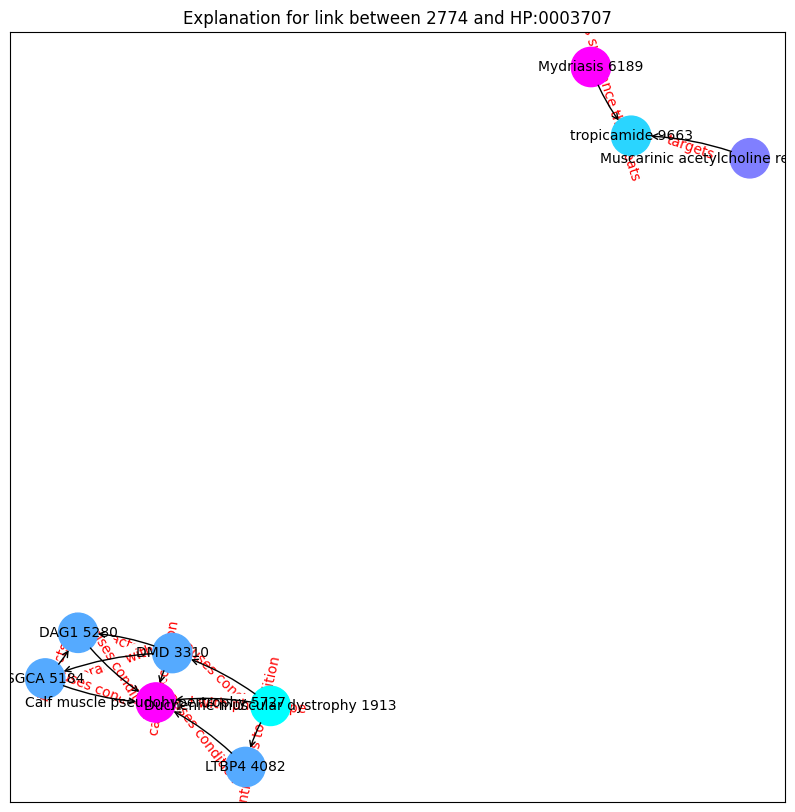

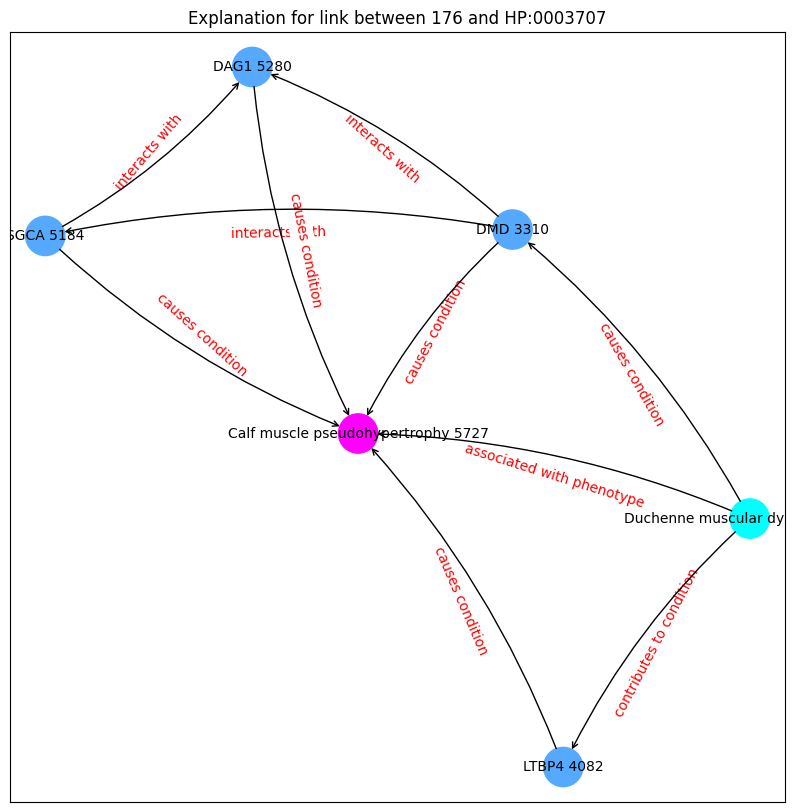

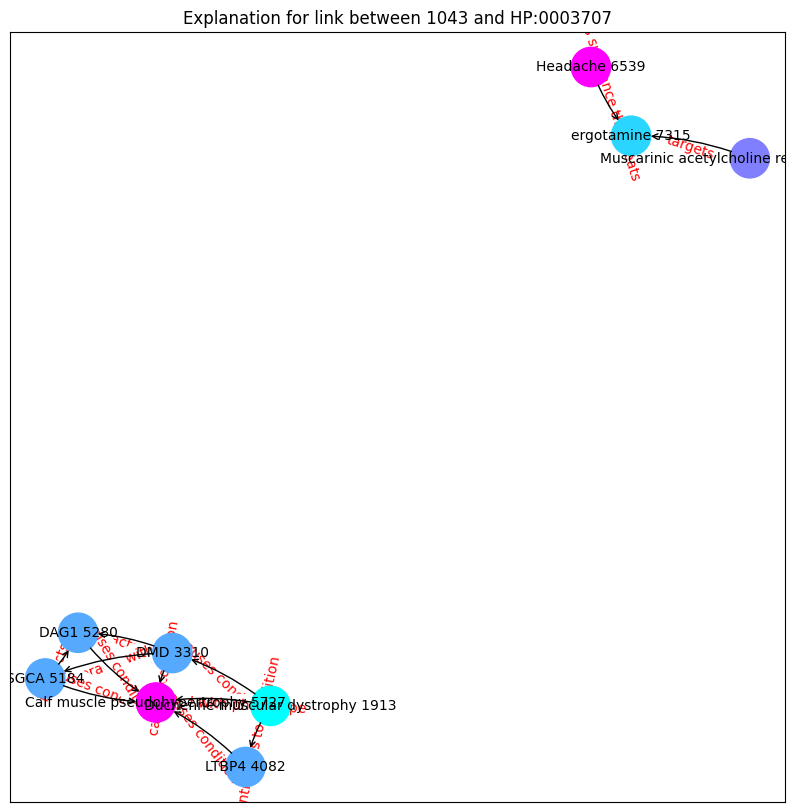

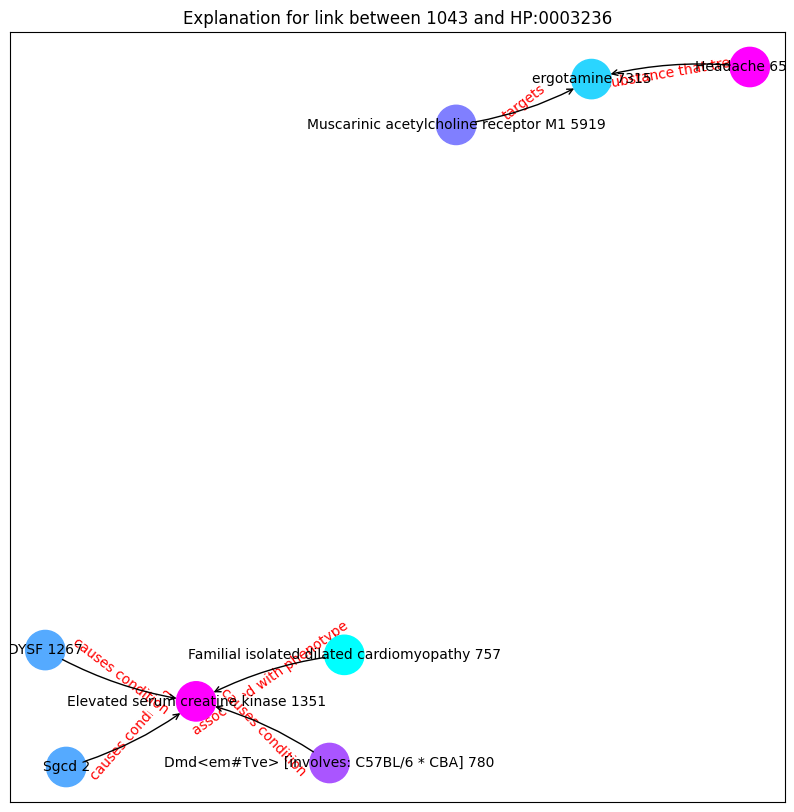

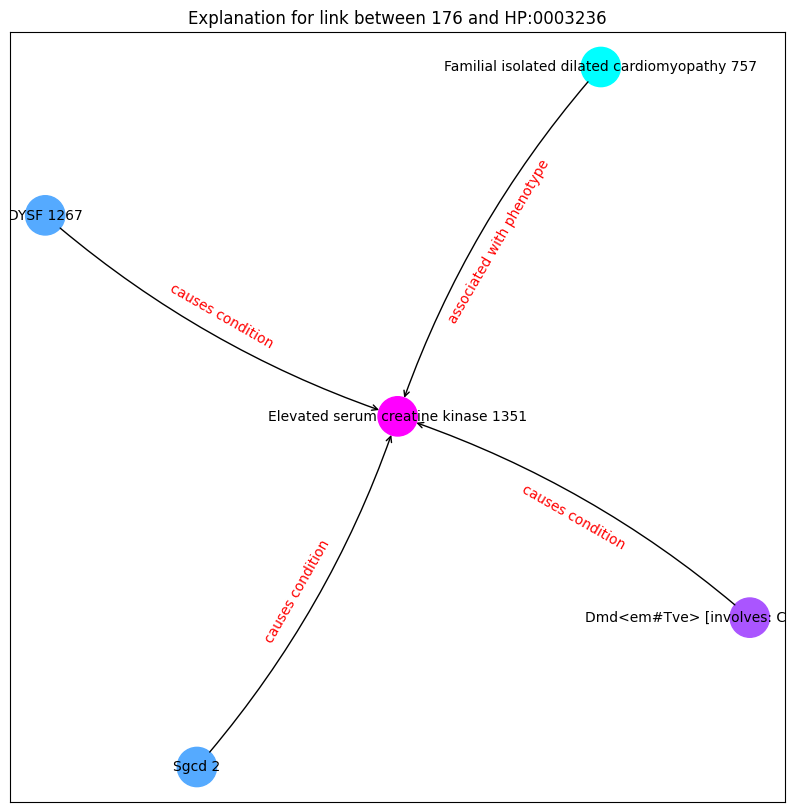

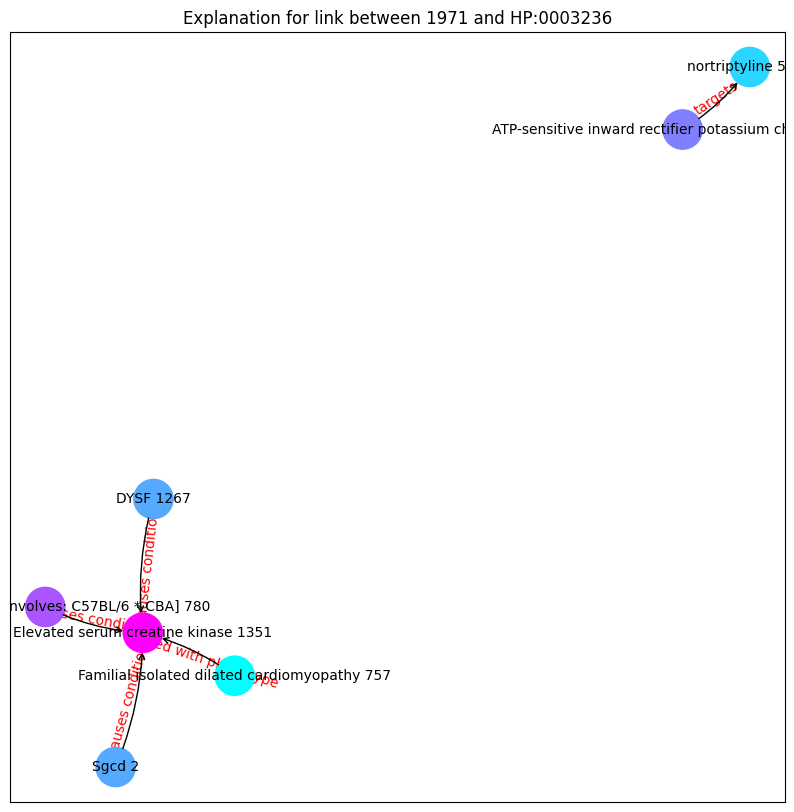

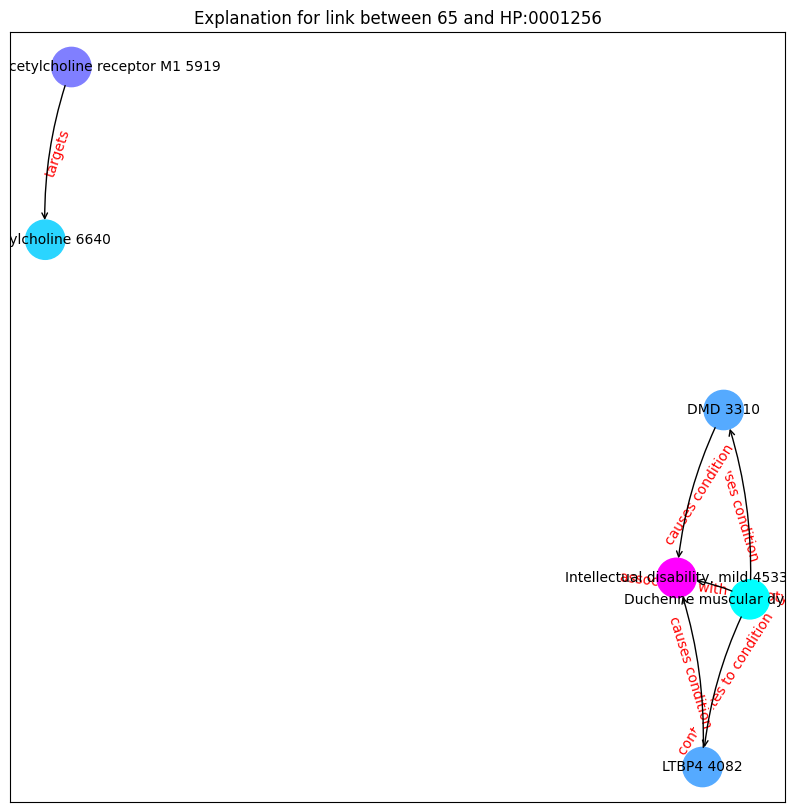

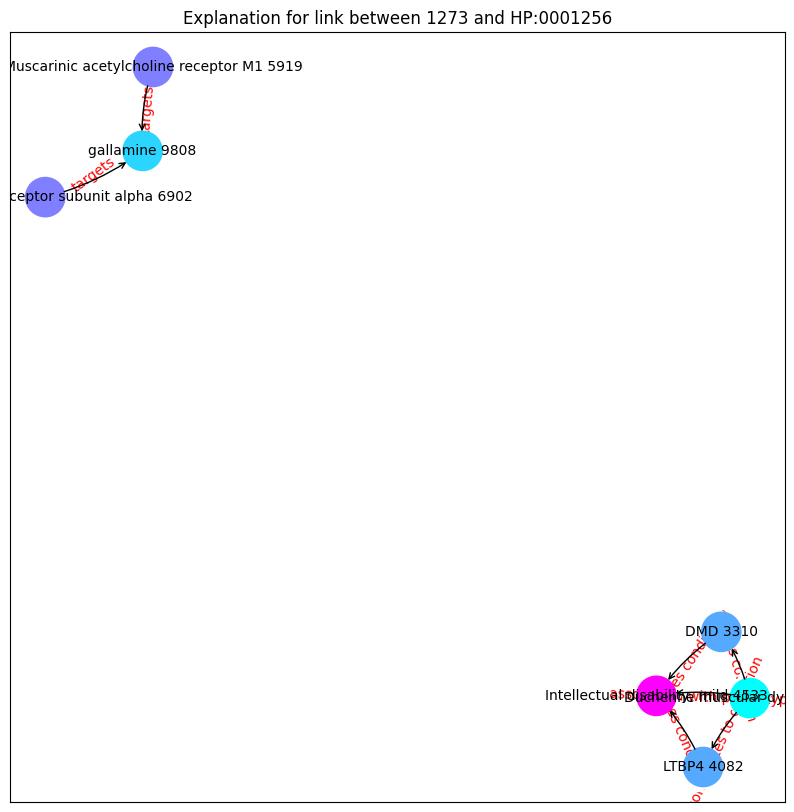

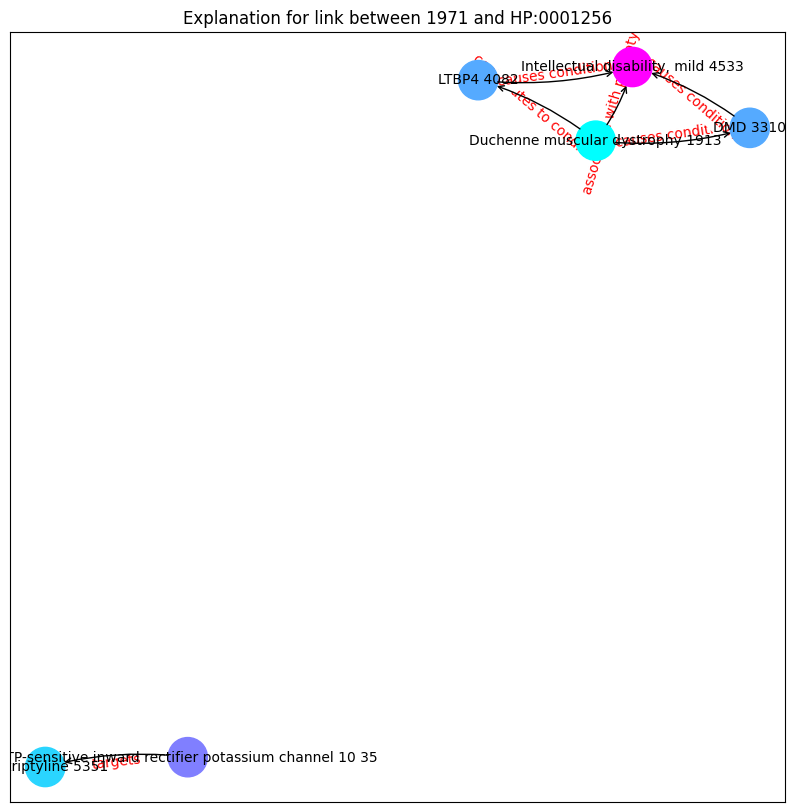

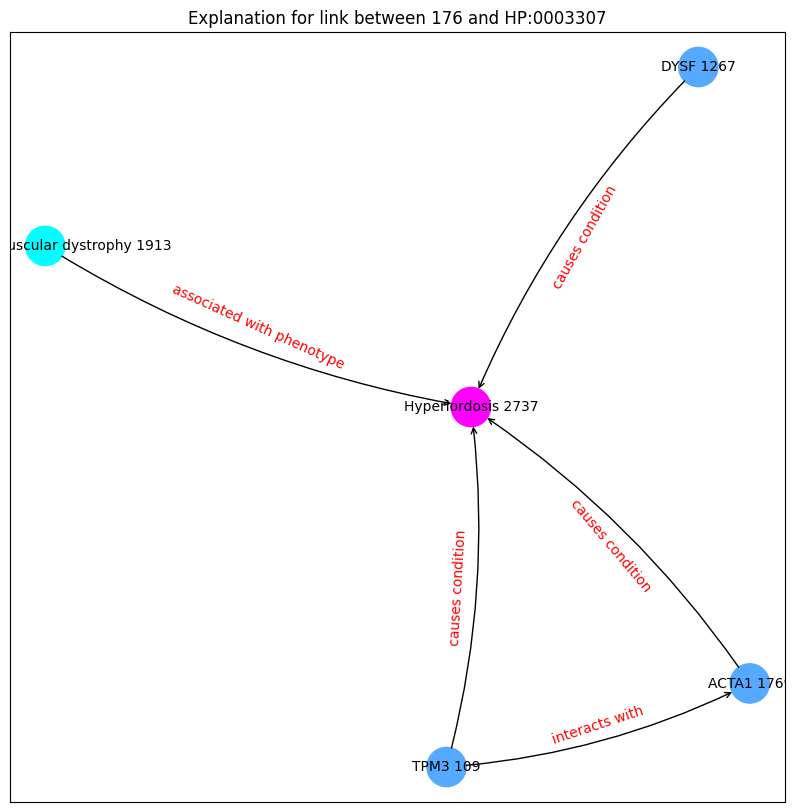

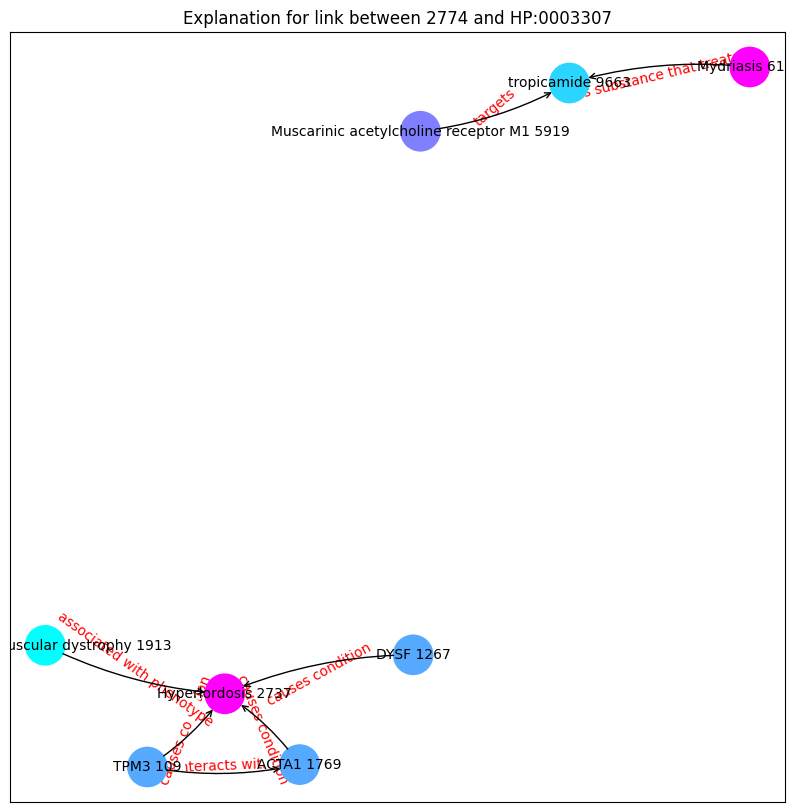

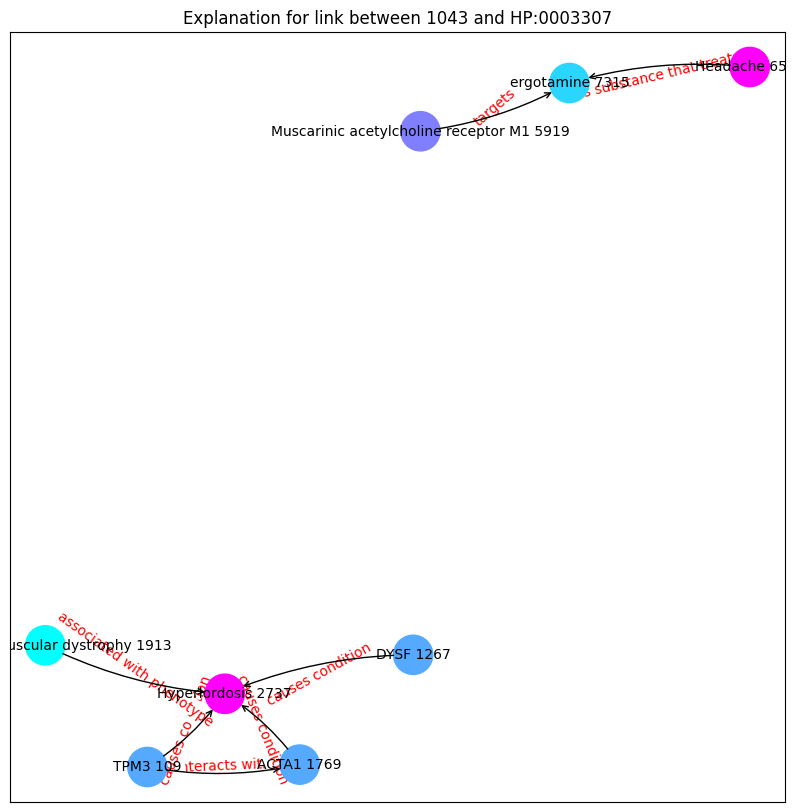

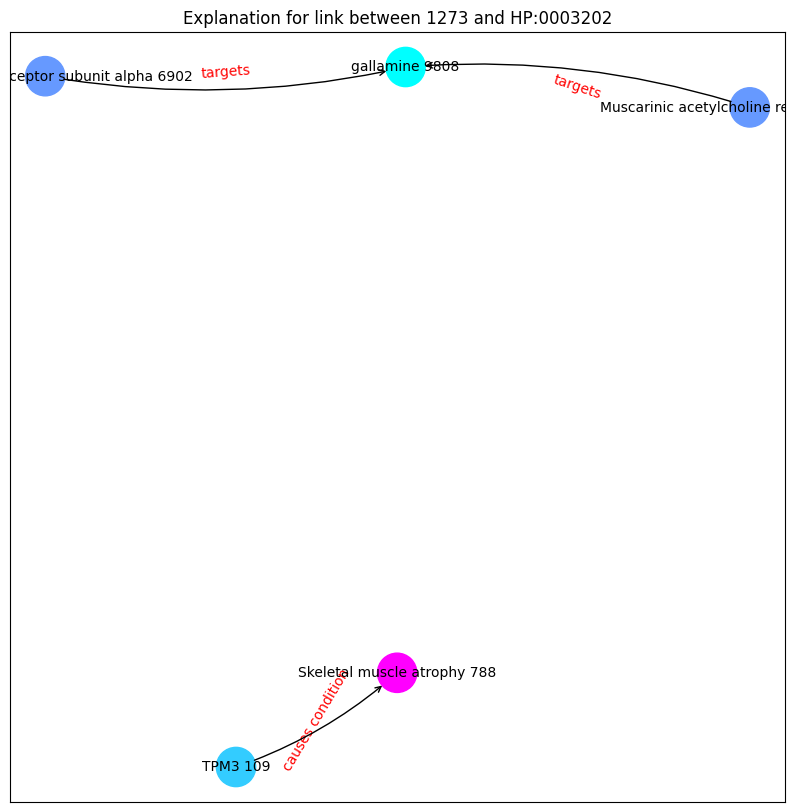

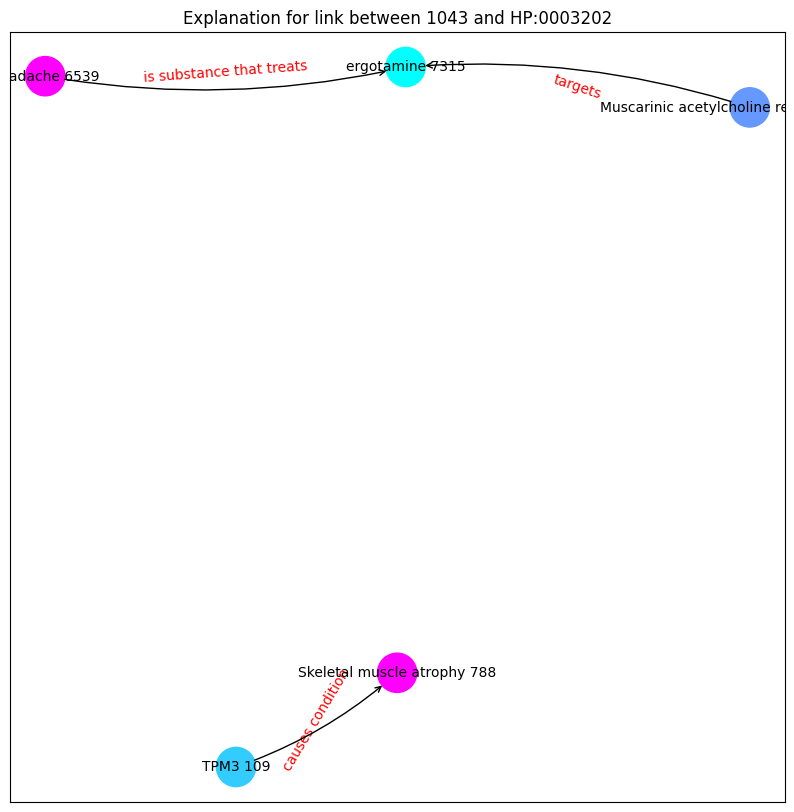

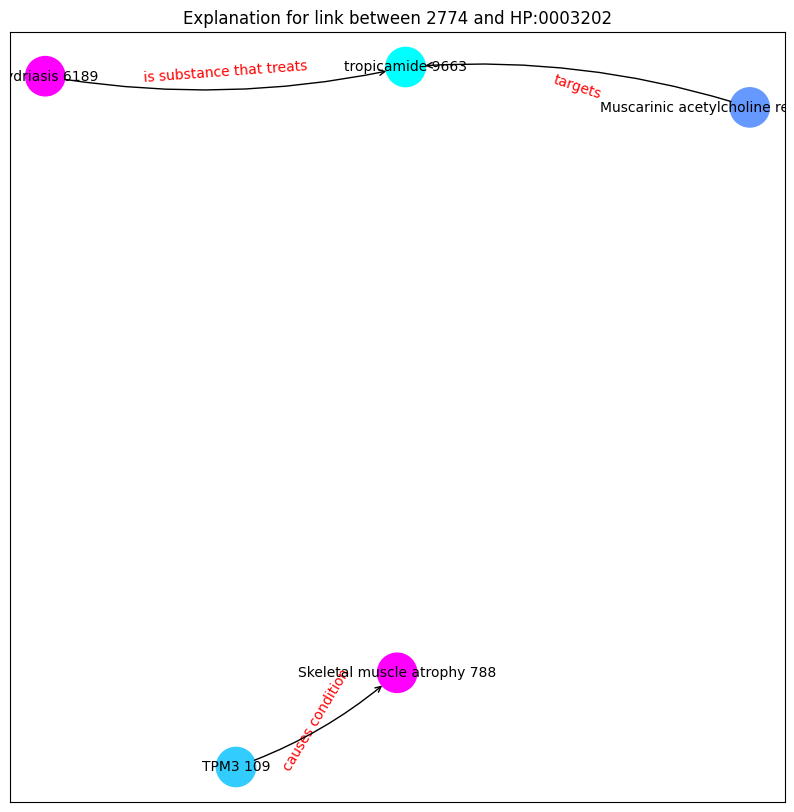

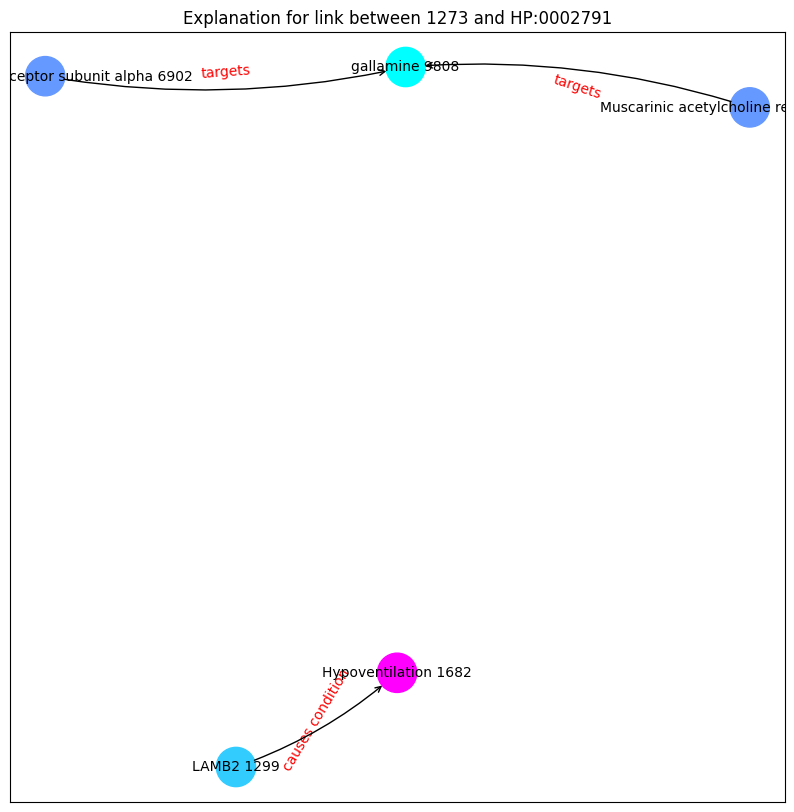

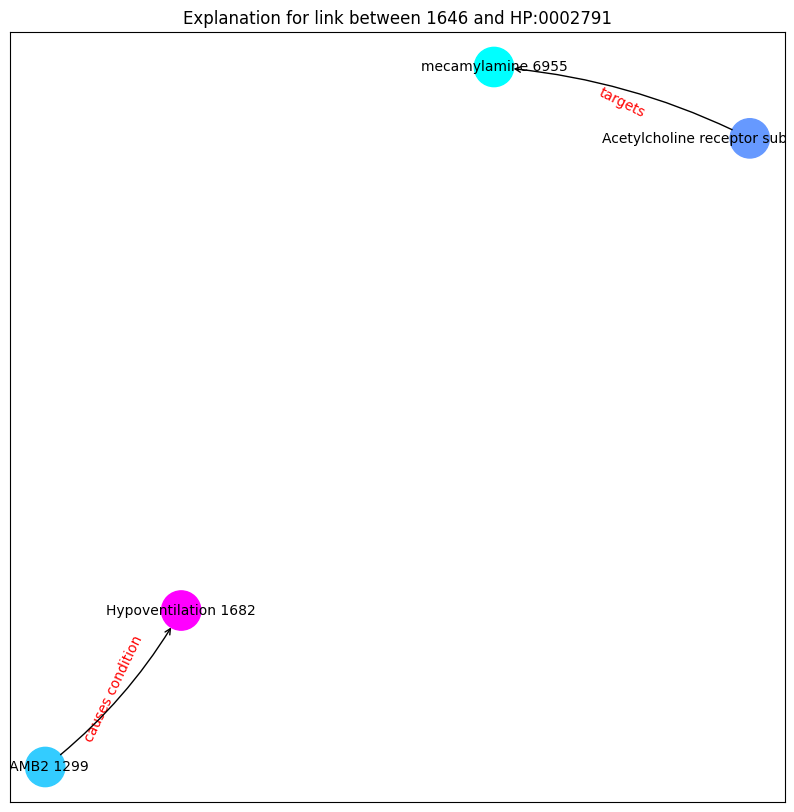

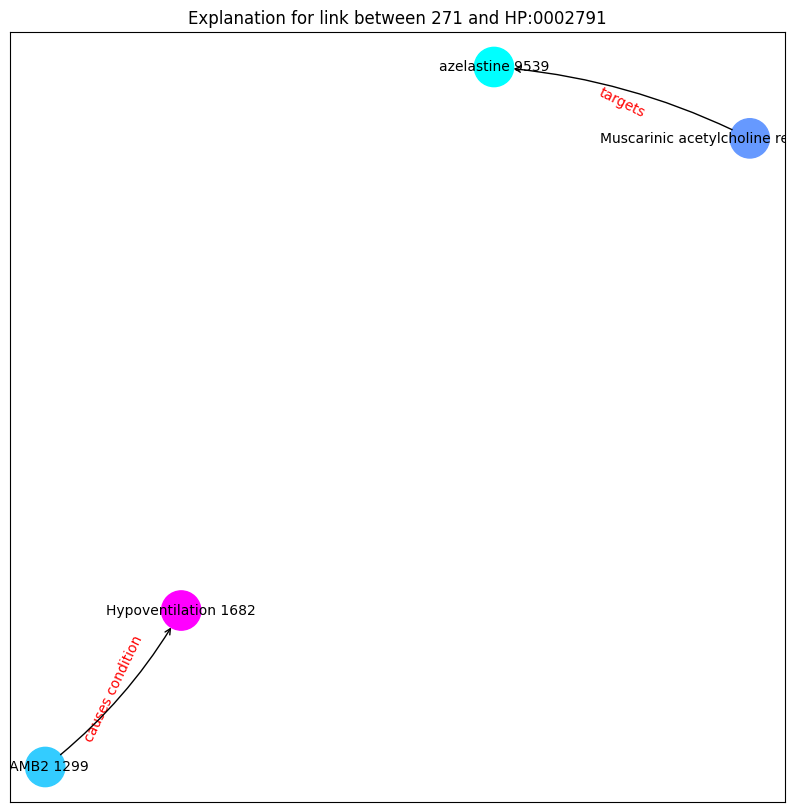

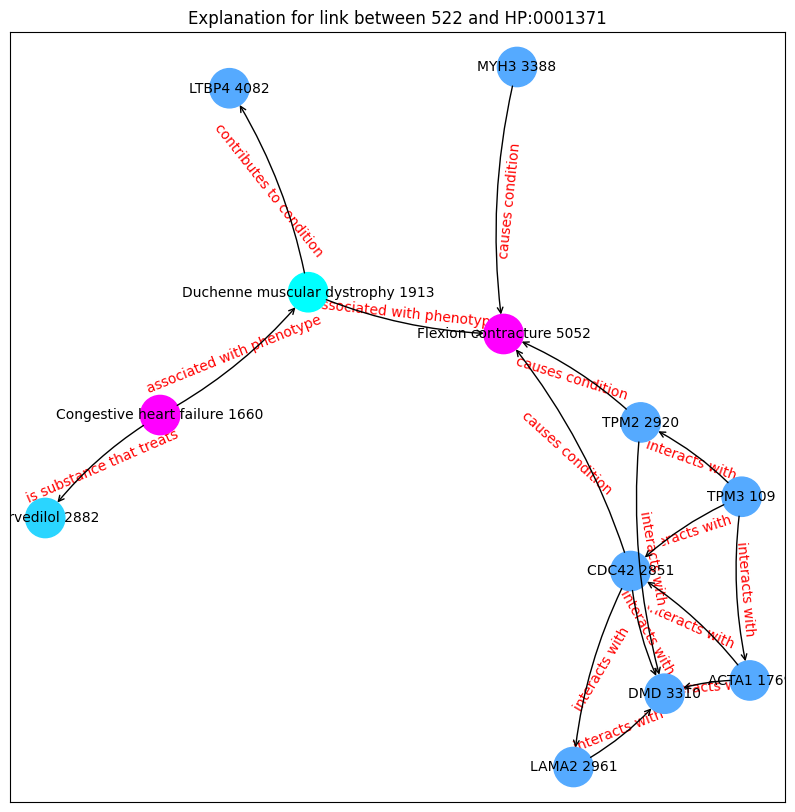

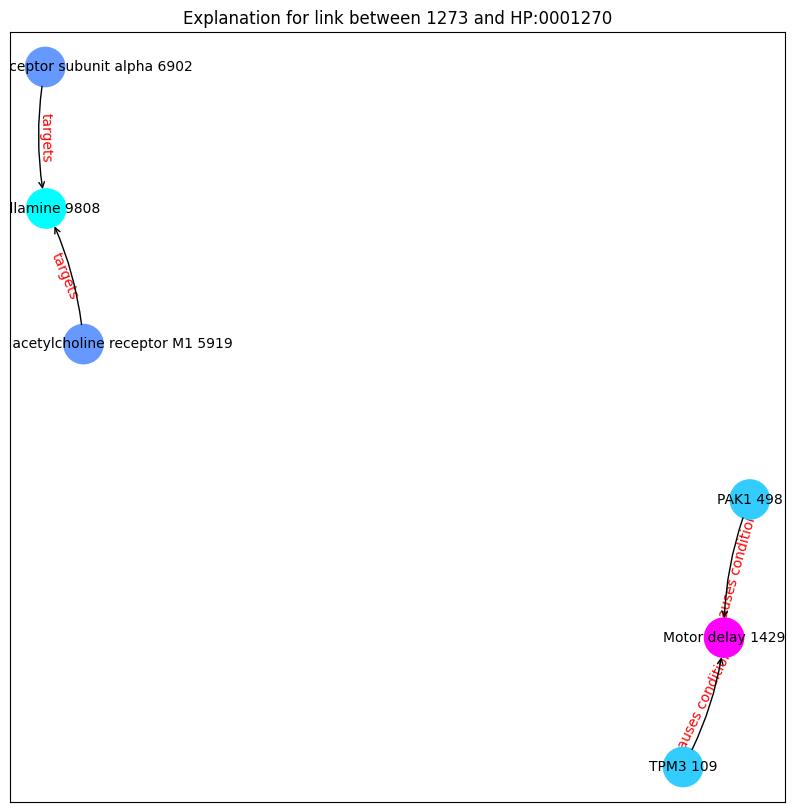

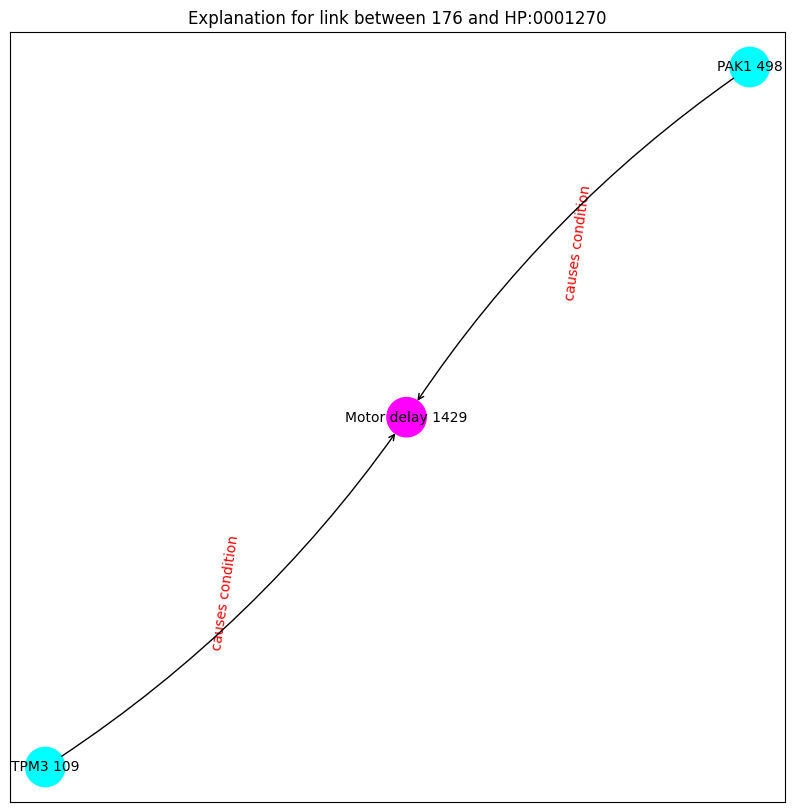

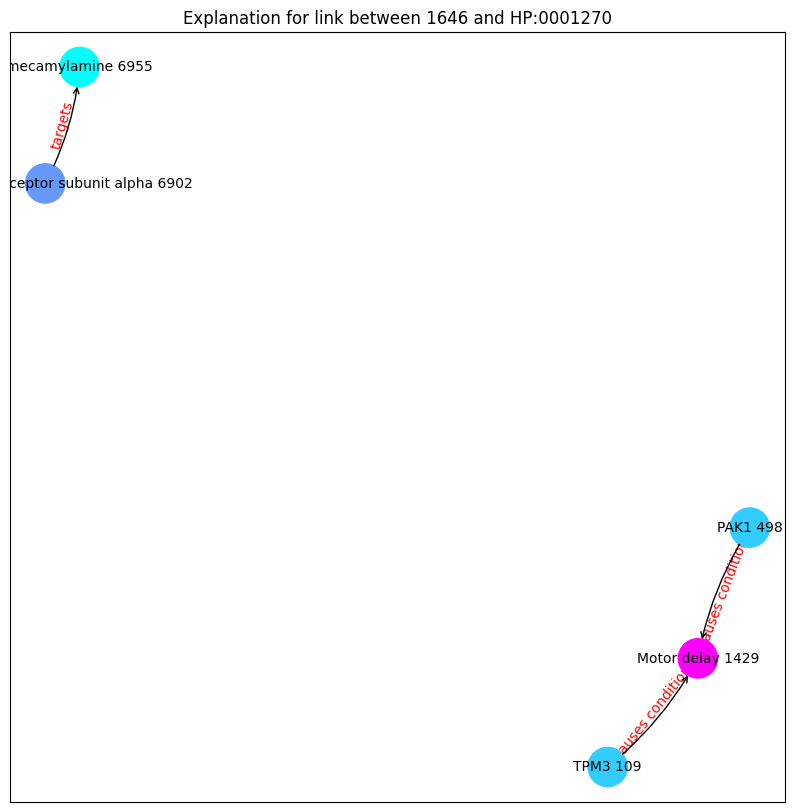

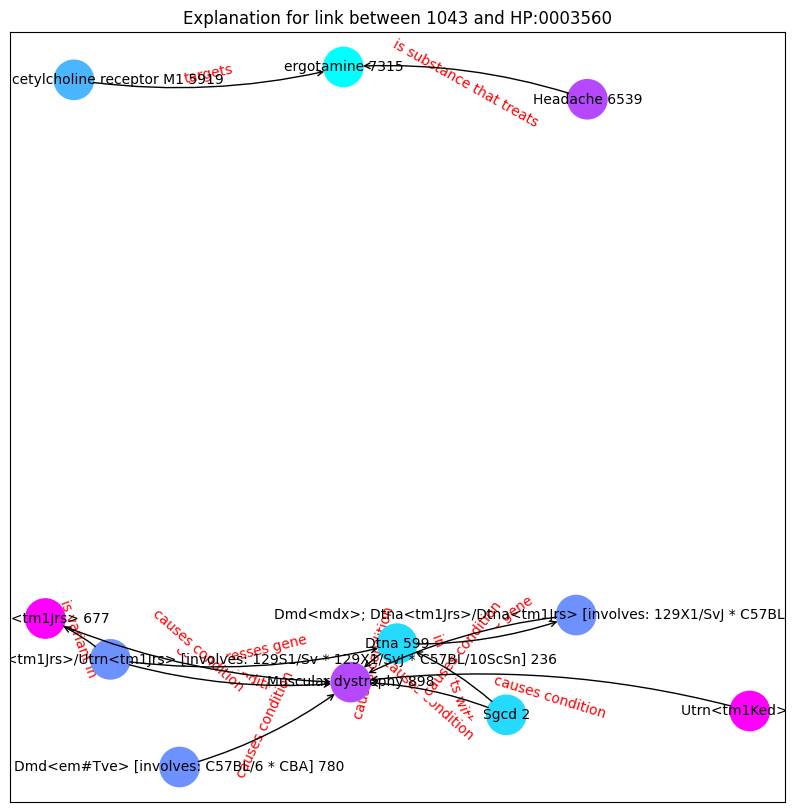

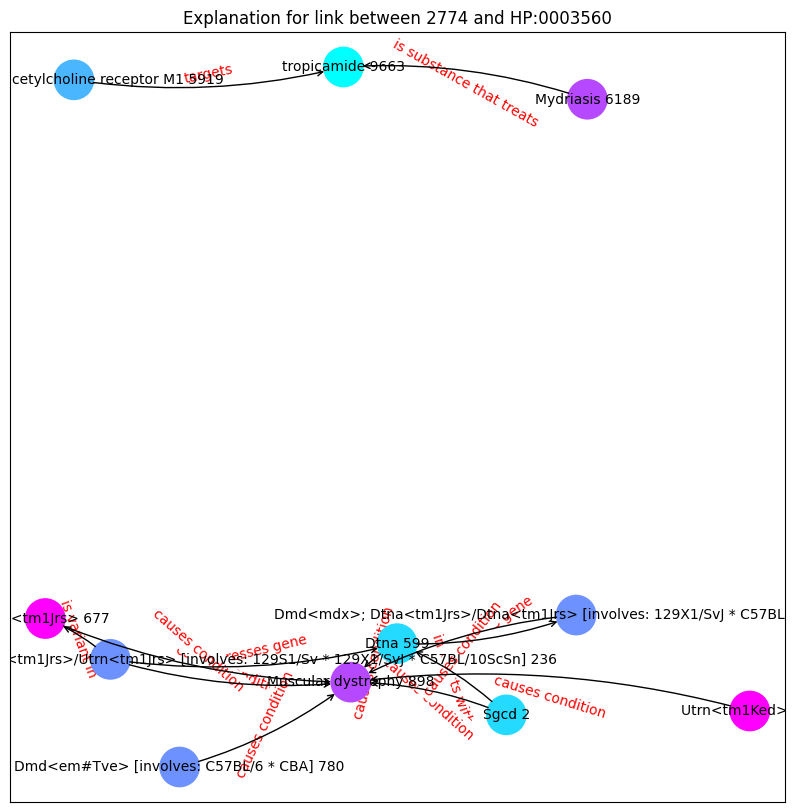

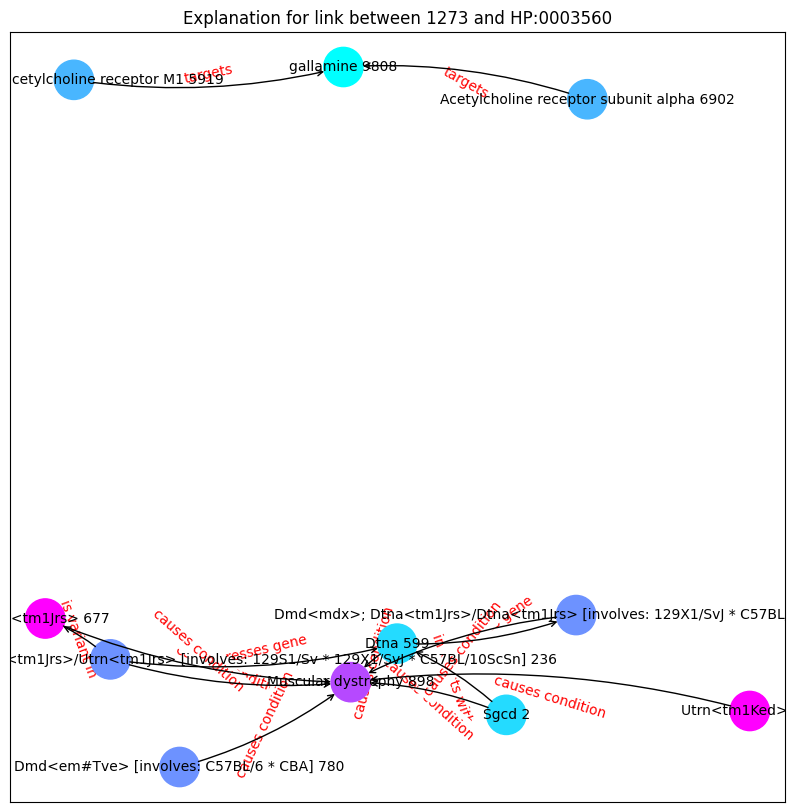

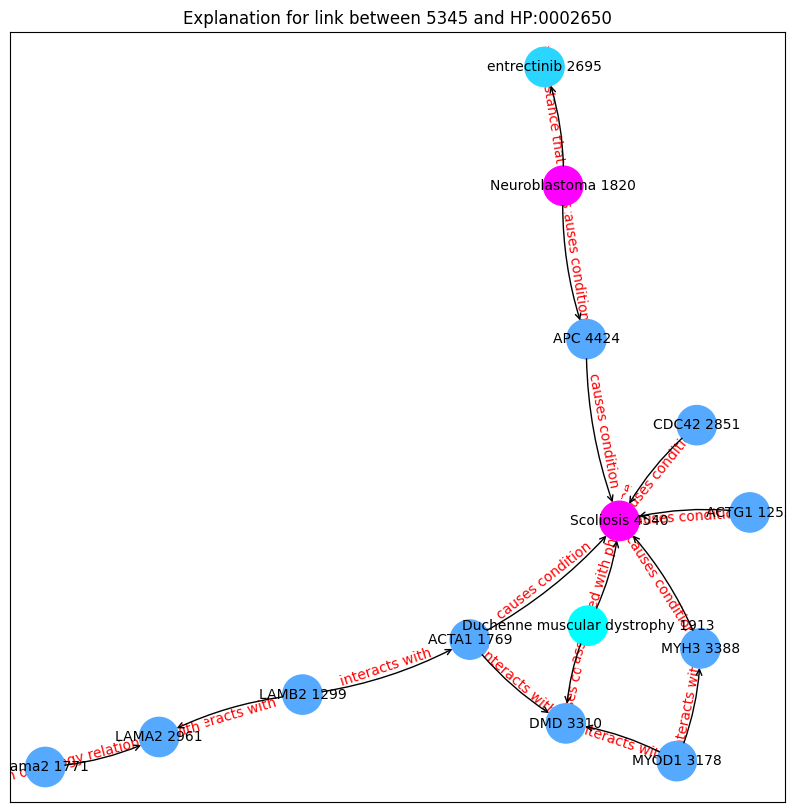

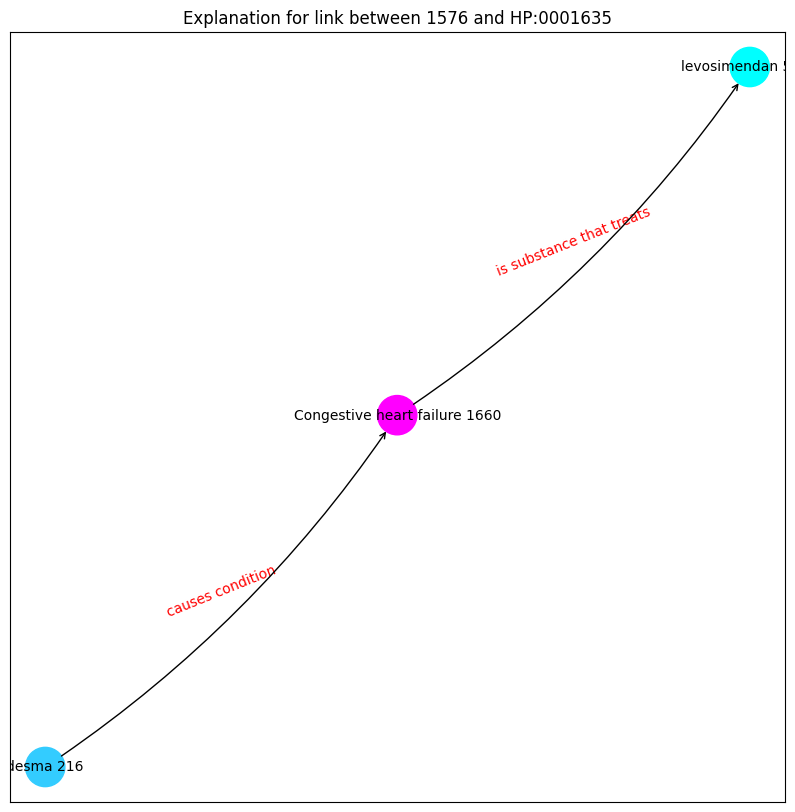

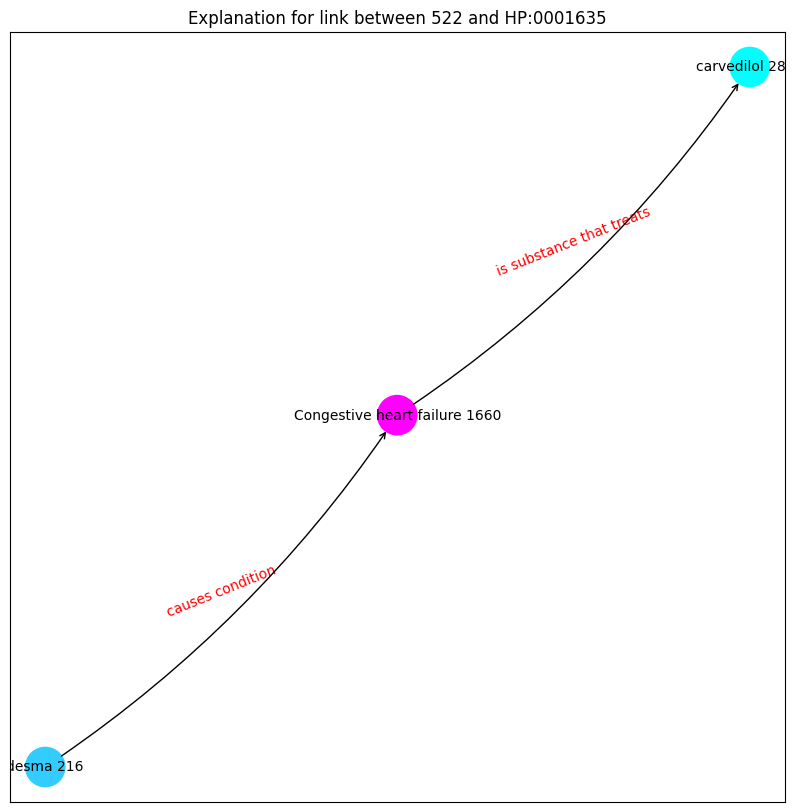

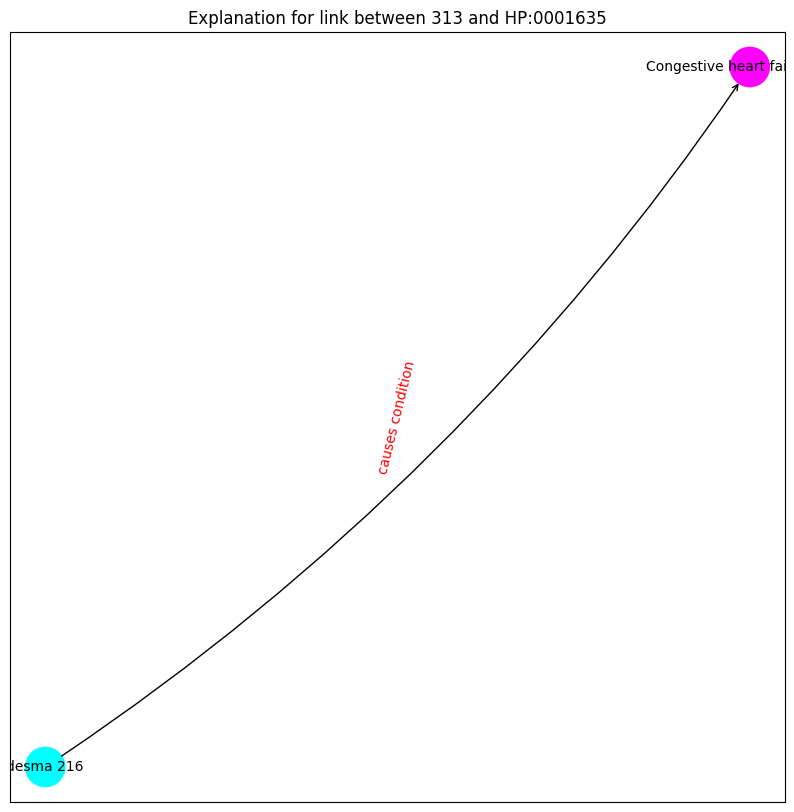

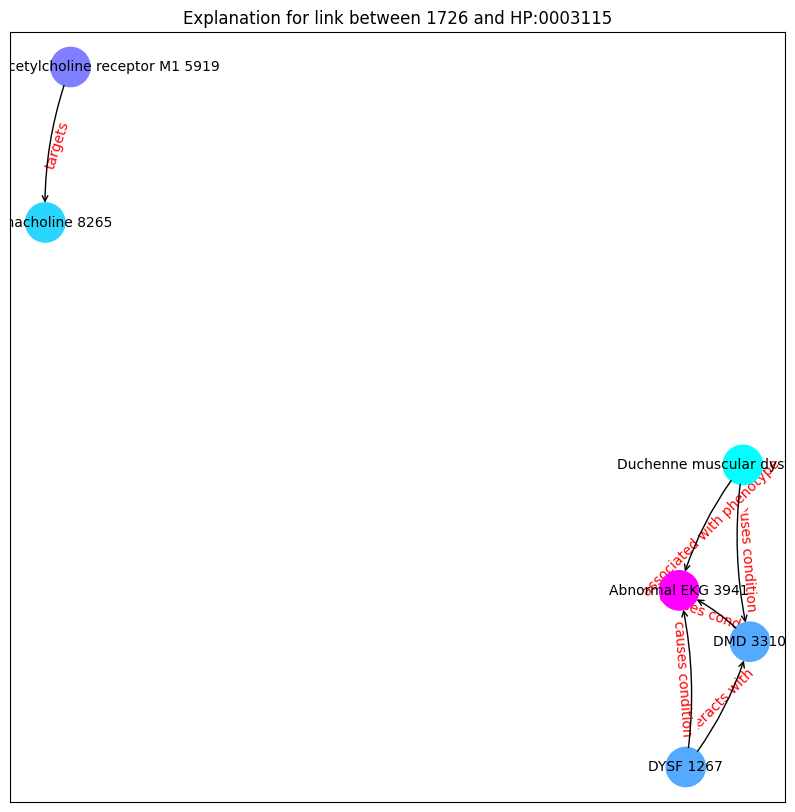

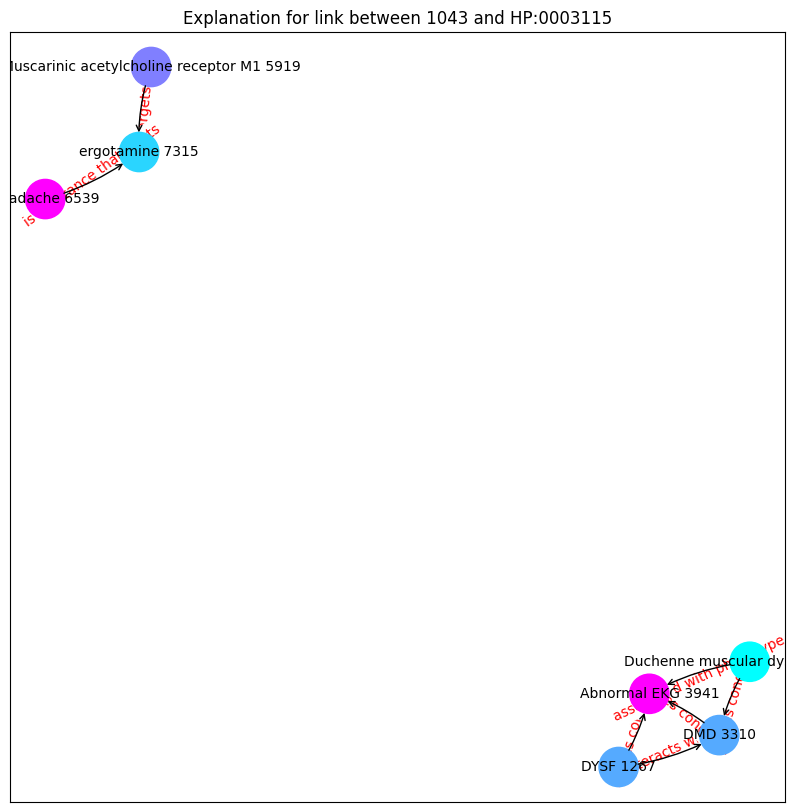

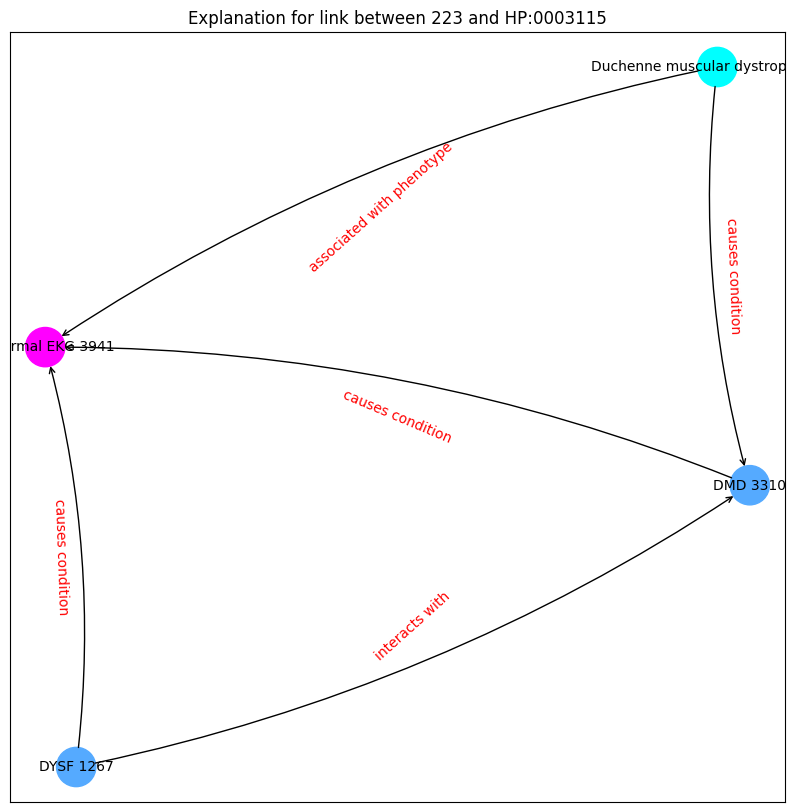

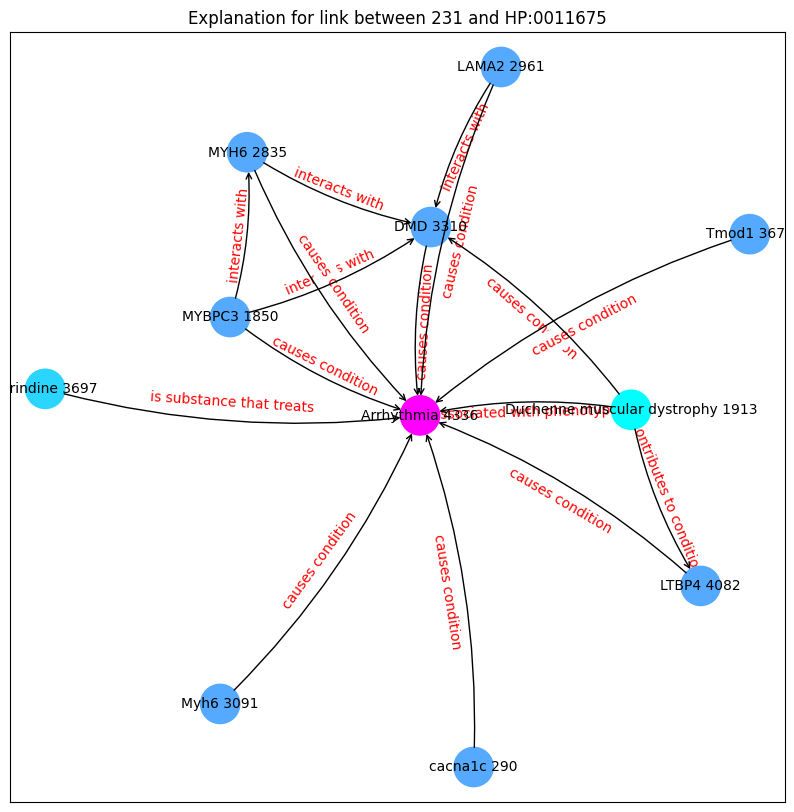

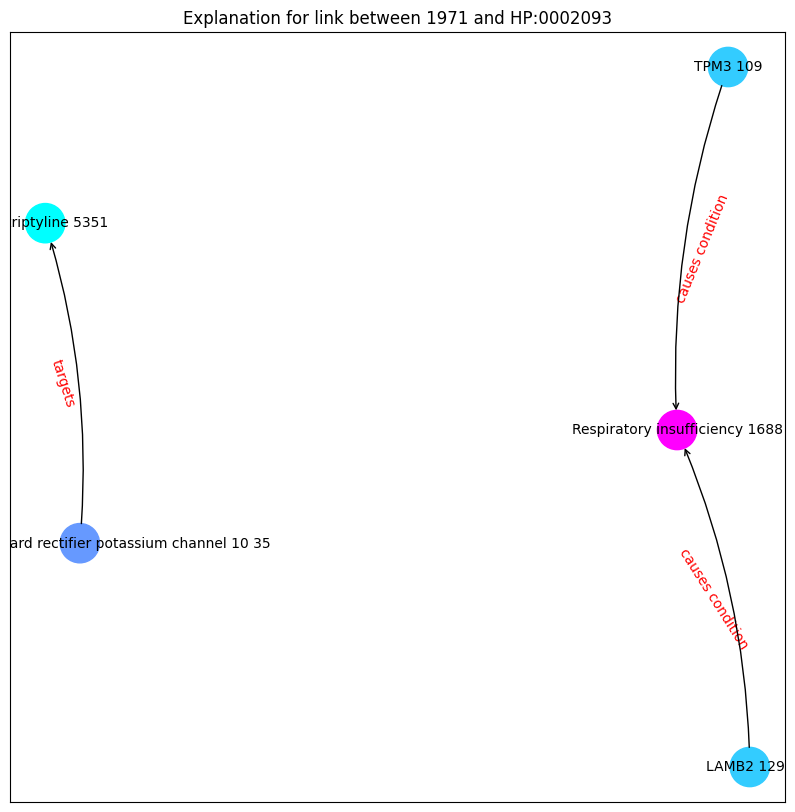

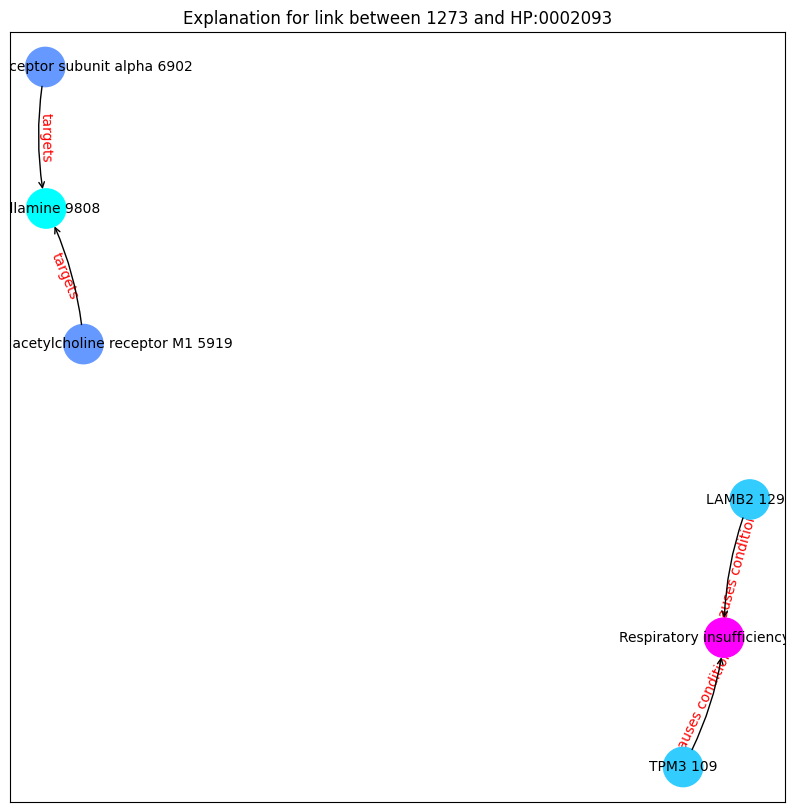

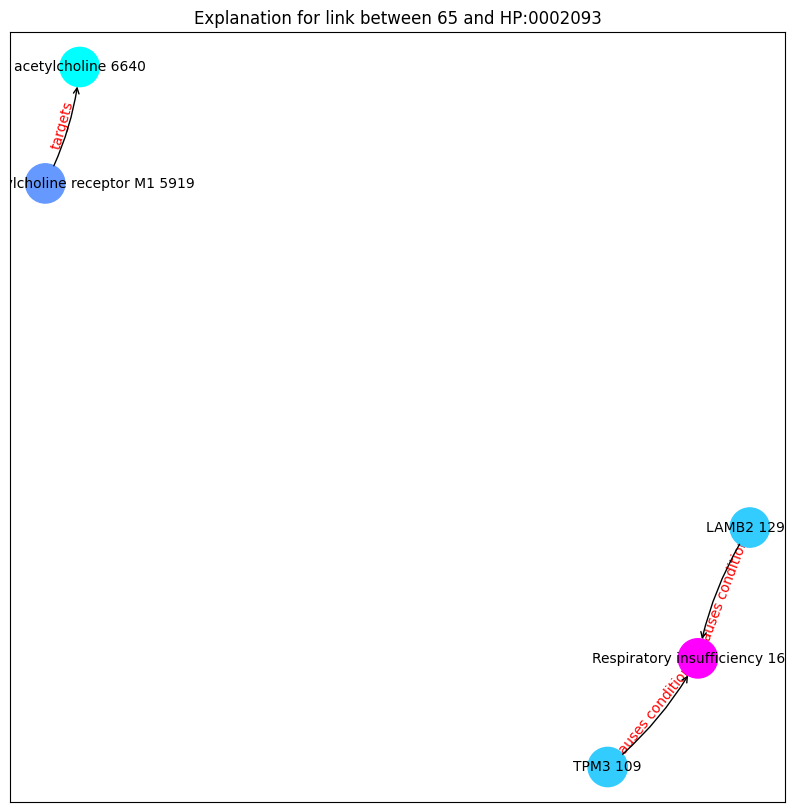

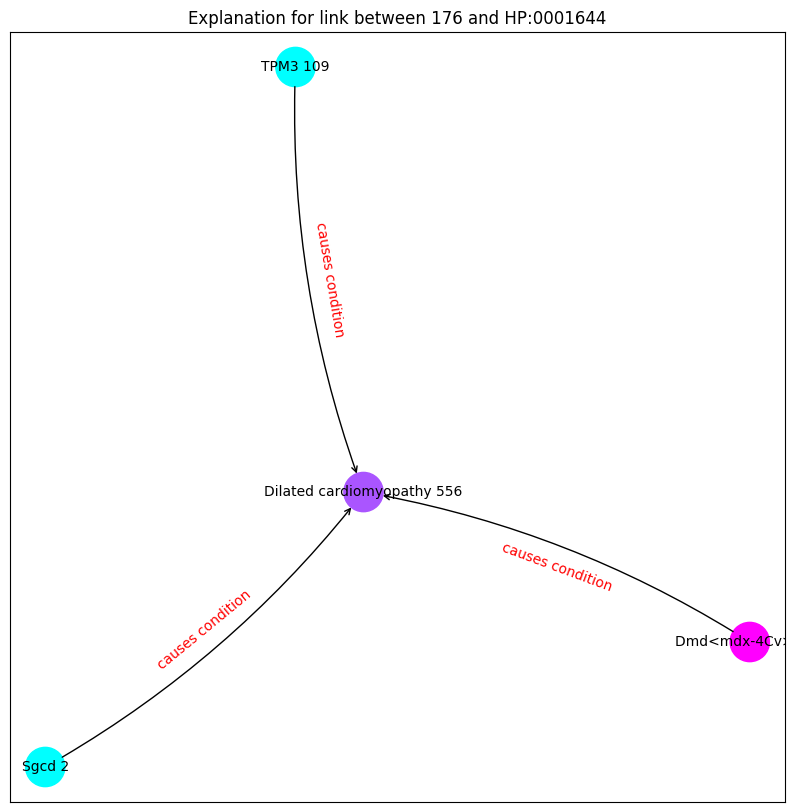

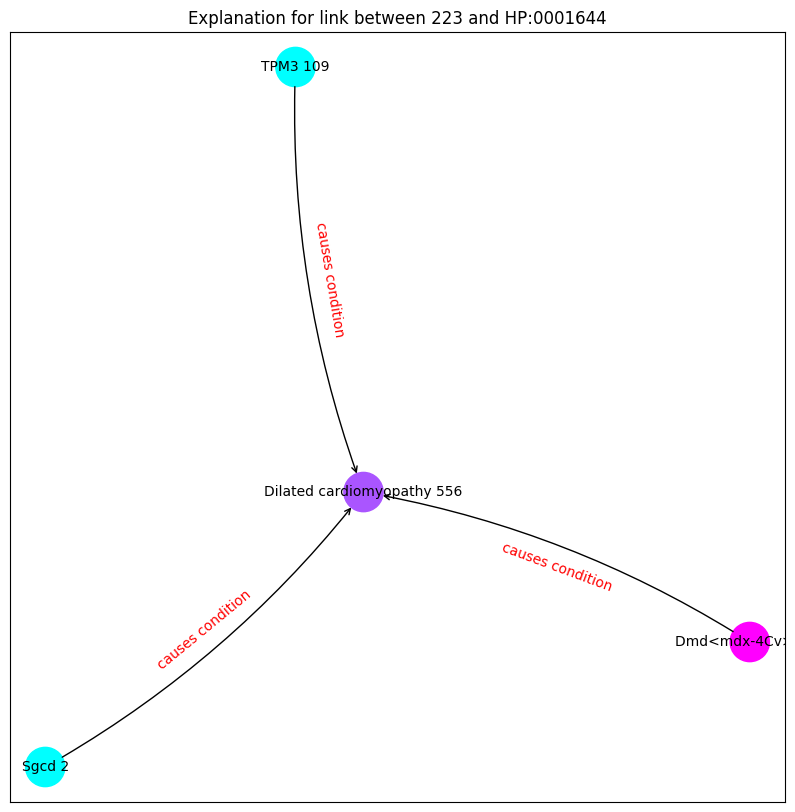

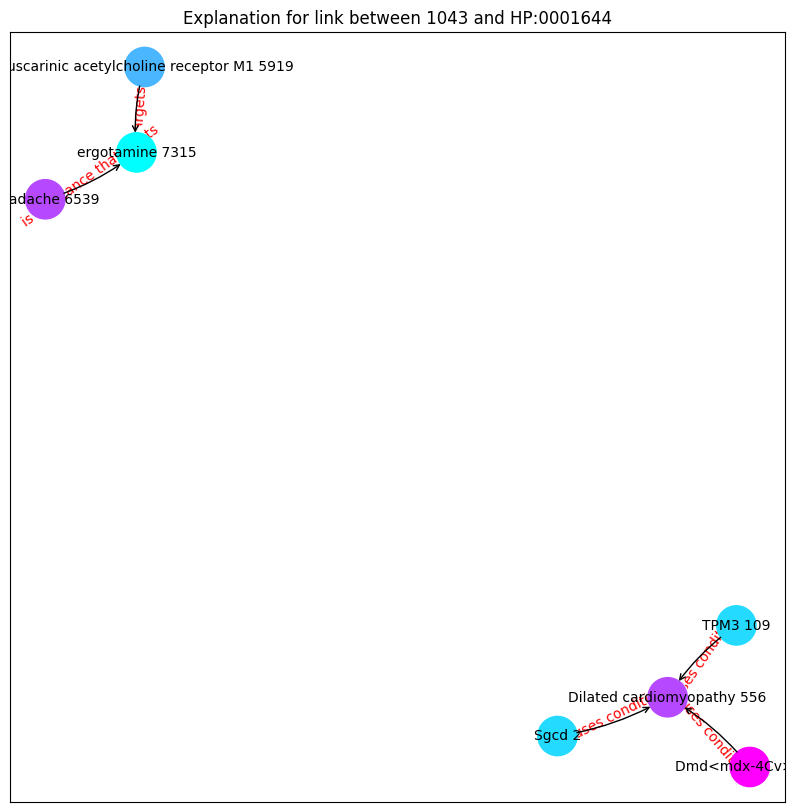

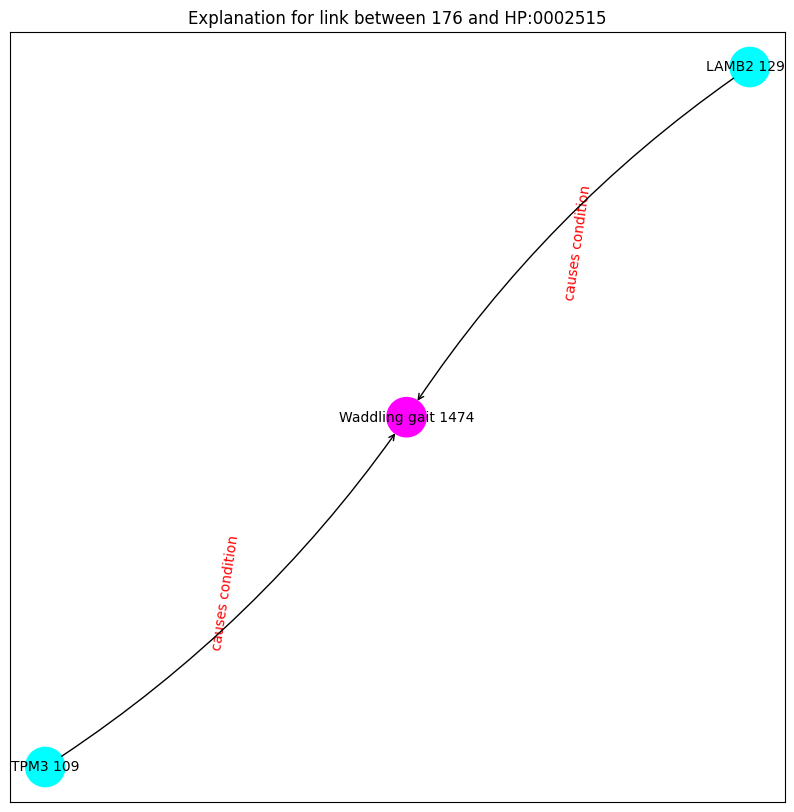

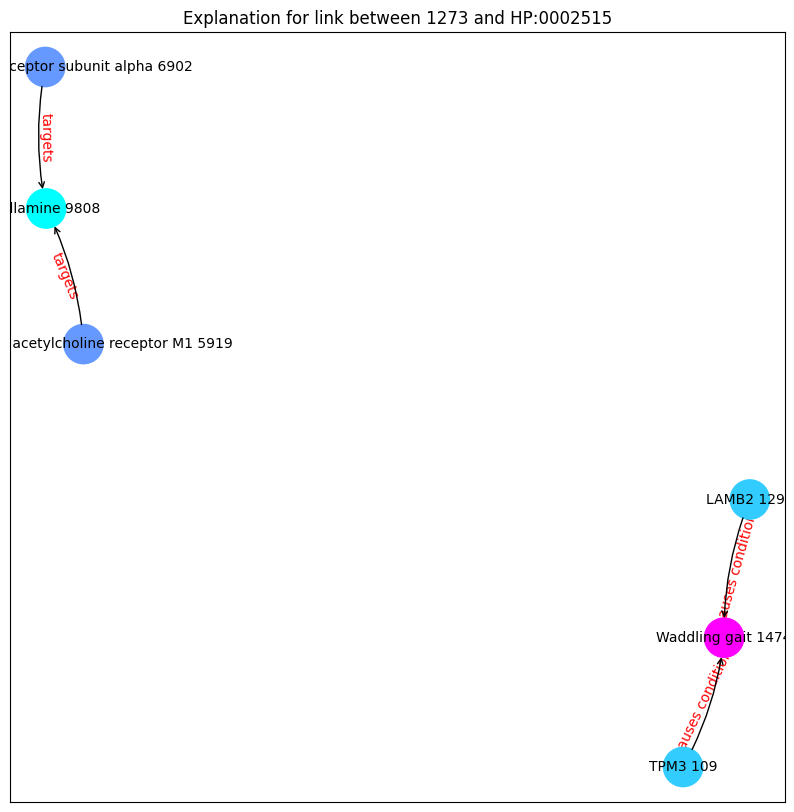

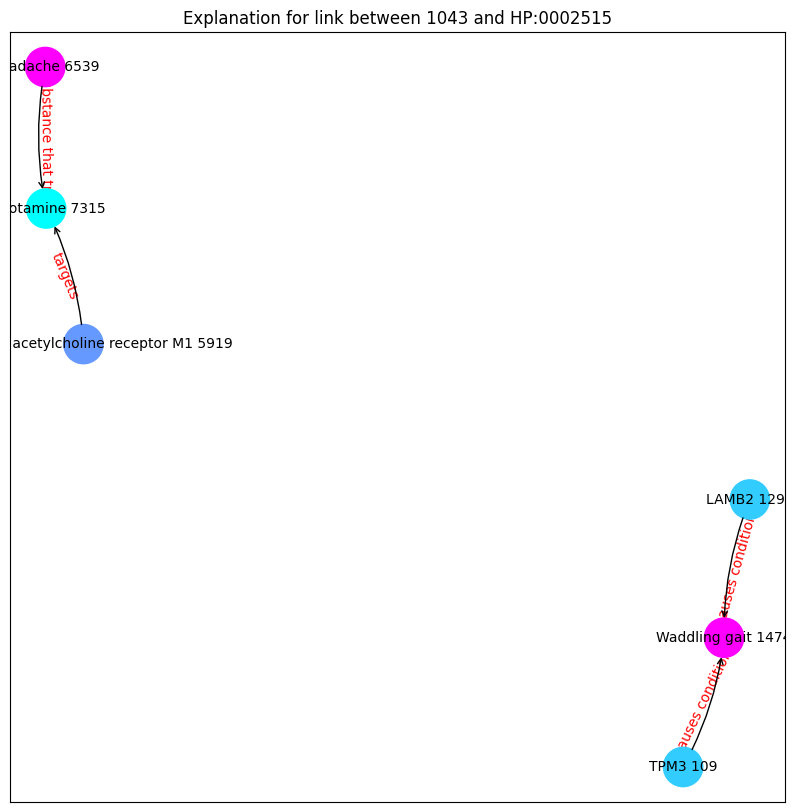

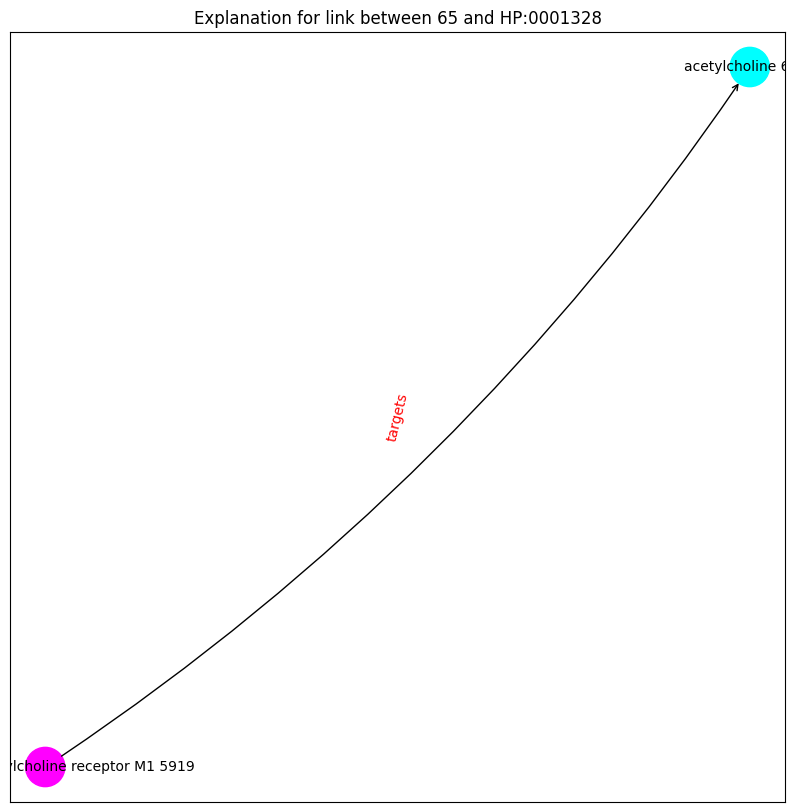

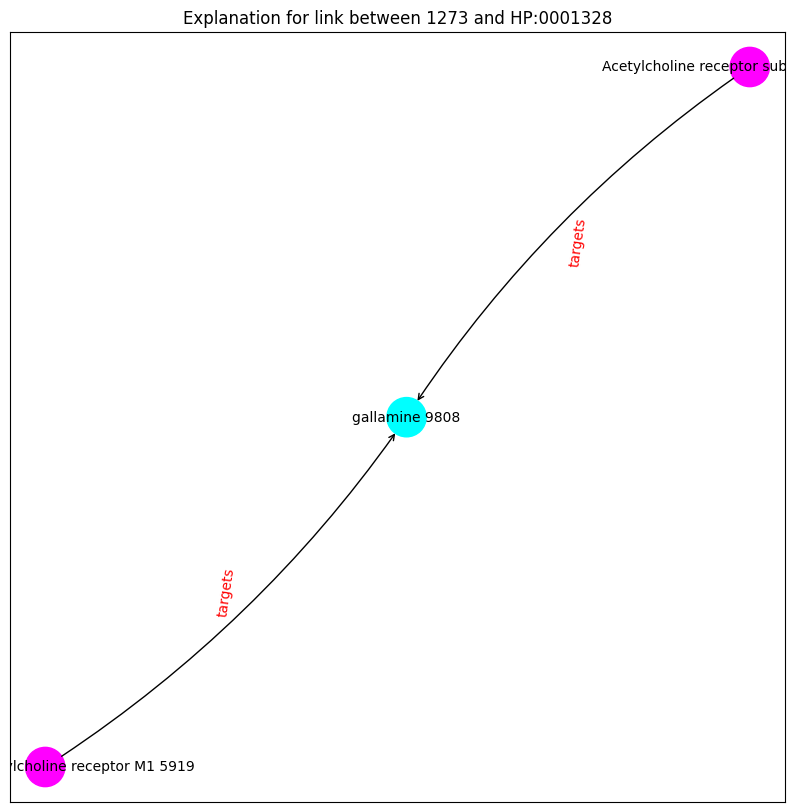

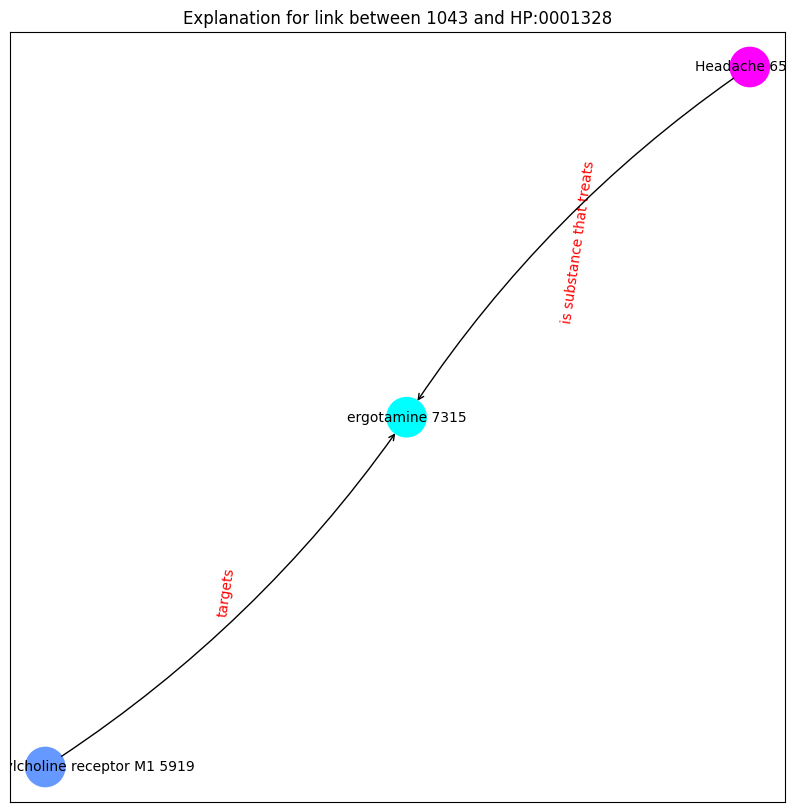

In [16]:
for i, explanation in enumerate(found_explanation):
    nodes_idxs = torch.Tensor([explanation['node_idx1'], explanation['node_idx2']]).long()

    plt.figure(figsize=(10, 10))
    plt.title(f"Explanation for link between {explanation['drug']} and {explanation['symptom']}")
    ax, G_sub = visualize_subgraph(nodes_idxs, edge_index, explanation['found_edge_mask'], nodes = nodes, y=torch.Tensor(nodes.semantic_id), seed = 667, num_hops = 1, threshold=explanation['found_limit'], node_label = 'label', edge_labels = edge_labels_dict, show_inactive = False, remove_unconnected = True)
    plt.show()

Really dependent on parameter of trained model.